<a href="https://colab.research.google.com/github/andreytusur/andreytusur/blob/main/final_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Итоговая работа по курсу "Разработка нейронных сетей на Python с нуля"

# Классификация горных пород и детекция угольных пластов по геофизическим данным

## Описание проекта
Данная работа является исследовательским проектом комплексного решения для автоматической классификации литологии и идентификации угольных пластов на основе данных геофизических исследований скважин (ГИС). Проект объединяет методы машинного обучения и глубокие нейронные сети для анализа многомерных геофизических данных.

## Цели проекта
- **Классификация литологии**: Многоклассовая классификация типов горных (вмещающих) пород;
- **Детекция угольных пластов**: Бинарная классификация для идентификации угольных интервалов;
- **Автоматизация интерпретации**: Создание инструмента для поддержки принятия геологических решений (в перспективе).

## Технологический стек
- **Python 3** + **TensorFlow/Keras** для глубокого обучения
- **Scikit-learn** для предобработки и классических ML методов
- **Pandas/NumPy** для обработки данных
- **Matplotlib/Seaborn** для визуализации
- **LASIO** для работы с геофизическими форматами

## Данные
### Источники данных:
- **Геофизические данные**: Файлы формата LAS  (каротажные кривые)
- **Литологические данные**: CSV файлы с описанием керна
- **Методы ГИС**: ГК, ГГК, ГГКС, КС, Кавернометрия, Проводимость

### Ключевые особенности данных:
- 524,442 обучающих примера
- 6 нормализованных геофизических признаков
- Многоклассовая классификация (литология) и бинарная классификация (уголь)

## Основные этапы обработки

### 1. Предобработка данных
- Чтение и парсинг LAS файлов
- Объединение разнородных данных
- Обработка пропущенных значений
- Нормализация в диапазон [0, 1]

### 2. Анализ и очистка
- Статистический анализ распределений
- Обнаружение и обработка выбросов (IQR, Winsorization)
- Анализ корреляций между методами ГИС
- Визуализация геофизических кривых

### 3. Генерация признаков (Feature Engineering)
- Создание бинарных меток для угля
- Кодирование категориальных переменных
- PCA анализ для снижения размерности
- Создание нормализованных признаков

## Модели машинного обучения

### Архитектуры нейронных сетей:
1. **Модель классификации литологии** (128 - 64 - 32 - N_classes)
2. **Модель детекции угля** (64 - 32 - 16 - 1)

### Ключевые особенности моделей:
- **BatchNormalization** для стабилизации обучения
- **Dropout** слои для регуляризации
- **Early Stopping** для предотвращения переобучения
- **ReduceLROnPlateau** для адаптивного обучения

## Метрики и оценка
- **Accuracy**: Общая точность классификации
- **Precision/Recall**: Для бинарной классификации угля
- **Validation Curves**: Мониторинг процесса обучения

## Ключевые результаты
- Успешное разделение литологических типов в пространстве признаков
- Высокая точность детекции угольных пластов
- Интерпретируемые модели с прозрачной архитектурой
- Автоматизированный пайплайн обработки данных

## Практическое применение
- Автоматизация интерпретации ГИС
- Поддержка геологического моделирования
- Оптимизация разведочных работ
- Снижение субъективности в интерпретации

## Предполагаемые улучшения
- Ансамблирование моделей
- Добавление геологических признаков
- Transfer learning для смежных месторождений

---

*Проект демонстрирует эффективное применение глубокого обучения для решения практических задач в геологии и разведке полезных ископаемых.*

## Подготовка рабочей среды

In [ ]:
# Загружаем сырые данные
!git clone https://gitflic.ru/project/apodlegaev/geo_dataset.git

fatal: destination path 'geo_dataset' already exists and is not an empty directory.


In [ ]:
# Устанавливаем необходимые библиотеки (модули)
!pip install colorlog lasio

In [ ]:
import glob
import logging
import os
import sys
import traceback
from typing import Dict, List, Tuple
from pathlib import Path

import colorlog
import lasio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats.mstats import winsorize


#Настройки
**Позволяет пропустить создание датасета и начать работу с готовым**

In [ ]:
# Параметр позволяет пропустить создание датасета из наборов файлов геофизики и геологии
# True - пропустить создание
# False - создать датасет

switch = True

## Создание датасета из исходных файлов с геофизическим данными .las и принятых данных по литологии .csv

**Обработка данных геофизики**

In [ ]:
# Режим отладки (были сложности с обработкой)
DEBUG = False

def setup_logger(name, log_file, level=logging.INFO):
    """Настройки логгера с выводом в файл и консоль"""

    # Создаем логгер с конкретным именем
    logger = colorlog.getLogger(name)
    logger.setLevel(level)

    # Очищаем существующие обработчики чтобы избежать дублирования
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)

    # Форматтер для цветного вывода в консоль
    console_formatter = colorlog.ColoredFormatter(
        '%(log_color)s%(asctime)s %(levelname)-8s%(reset)s %(blue)s%(message)s',
        datefmt='%Y-%m-%d %H:%M:%S',
        log_colors={
            'DEBUG': 'cyan',
            'INFO': 'green',
            'WARNING': 'yellow',
            'ERROR': 'red',
            'CRITICAL': 'red,bg_white',
        }
    )

    # Форматтер для файла (без цветов)
    file_formatter = logging.Formatter(
        '%(asctime)s %(levelname)-8s %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )

    # Файловый обработчик
    file_handler = logging.FileHandler(log_file, encoding='utf-8')
    file_handler.setFormatter(file_formatter)
    file_handler.setLevel(level)

    # Консольный обработчик
    console_handler = colorlog.StreamHandler(sys.stdout)
    console_handler.setFormatter(console_formatter)
    console_handler.setLevel(level)

    # Обработчики логгера
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

    # Отключаем распространение к корневому логгеру
    logger.propagate = False

    return logger

In [ ]:
# Конфигурируем логгирование
geo_logger = setup_logger('GreateGeoDataSet', 'greate_dataset_log.log', logging.DEBUG)

In [ ]:
# Создаем базовый маппинг типов кривых
CURVE_PATTERNS = {
    'KC': ['LL3'],  # КС - кажущееся сопротивление
    'ГК': ['GR'],  # Гамма-каротаж
    'ГГК': ['GGR'],  # Гамма-гамма каротаж
    'Кавернометрия': ['CALI'],  # Кавернометрия
    'ГГКС': ['RGGR']  # Гамма-гамма каротаж селективный
}

In [ ]:
def extract_well_metadata(las, file_path: str) -> Dict:
    """Извлекает все метаданные из секции ~Well Information Block"""
    metadata = {
        'Файл': os.path.basename(file_path),
        'Скважина': os.path.splitext(os.path.basename(file_path))[0]
    }
    geo_logger.info(f"Начало обработки: \nФайл: {metadata['Файл']} \nСкважина: {metadata['Скважина']}")

    # Извлекаем все параметры из секции ~Well
    if hasattr(las, 'well') and las.well:
        for item in las.well:
            param_name = item.mnemonic
            param_value = item.value
            param_unit = item.unit if hasattr(item, 'unit') else ''
            param_descr = item.descr if hasattr(item, 'descr') else ''

            # Сохраняем параметр
            metadata[param_name] = param_value

            # Дополнительно сохраняем описание и единицы измерения если они есть
            if param_unit:
                metadata[f'{param_name}_UNIT'] = param_unit
            if param_descr:
                metadata[f'{param_name}_DESCR'] = param_descr

    return metadata

In [ ]:
def extract_curve_information(las) -> pd.DataFrame:
    """Формирует датафрейм с информацией о кривых из секции ~Curve Information Block"""
    curve_data = []

    if hasattr(las, 'curves') and las.curves:
        for curve in las.curves:
            curve_info = {
                'MNEMONIC': curve.mnemonic,
                'UNIT': curve.unit if hasattr(curve, 'unit') else '',
                'DESCRIPTION': curve.descr if hasattr(curve, 'descr') else '',
                'VALUE': curve.value if hasattr(curve, 'value') else '',
                'API_CODE': curve.api_code if hasattr(curve, 'api_code') else ''
            }
            curve_data.append(curve_info)

    return pd.DataFrame(curve_data)

In [ ]:
def merge_curve_data(df: pd.DataFrame, curve_names: List[str]) -> pd.Series:
    """Объединяет данные из нескольких кривых с одинаковым паттерном"""
    if not curve_names:
        return pd.Series(np.nan, index=df.index)

    # Собираем все не NaN данные
    valid_data = []
    for curve_name in curve_names:
        if curve_name in df.columns:
            curve_series = df[curve_name].dropna()
            if not curve_series.empty:
                valid_data.append((curve_series.index, curve_series.values))

    if not valid_data:
        return pd.Series(np.nan, index=df.index)

    result = np.full(len(df), np.nan)

    # Заполняем в порядке приоритета
    for indices, values in valid_data:
        result[indices] = values

    return pd.Series(result, index=df.index)

In [ ]:
def find_all_curves_by_pattern(curve_names: List[str], patterns: List[str], debug: bool = False) -> List[str]:
    """Находит кривые, соответствующие GR/GGR/RGGR"""
    matches = []

    if debug:
        geo_logger.info(f"Поиск данных для мнемоники {patterns}")

    for pattern in patterns:
        pattern_upper = pattern.upper().strip()

        for curve_name in curve_names:
            curve_name_upper = curve_name.upper().strip()

            if debug:
                geo_logger.info(f"Проверка: '{curve_name}' -> '{pattern_upper}'")

            if pattern_upper in ['GR', 'GGR', 'RGGR']:
                if pattern_upper == 'GR':
                    if (curve_name_upper == 'GR' or
                            curve_name_upper.startswith('GR.') or
                            curve_name_upper.startswith('GR:') or
                            curve_name_upper.startswith('GR_') or
                            curve_name_upper.startswith('GR-') or
                            (curve_name_upper.startswith('GR') and len(curve_name_upper) == 2)):
                        if 'GGR' not in curve_name_upper and 'RGGR' not in curve_name_upper:
                            matches.append(curve_name)
                            if debug:
                                geo_logger.info(f"Найдены данные ГК: '{curve_name}'")

                elif pattern_upper == 'GGR':
                    if (curve_name_upper == 'GGR' or
                            curve_name_upper.startswith('GGR.') or
                            curve_name_upper.startswith('GGR:') or
                            curve_name_upper.startswith('GGR_') or
                            curve_name_upper.startswith('GGR-') or
                            (curve_name_upper.startswith('GGR') and len(curve_name_upper) == 3)):
                        if 'RGGR' not in curve_name_upper:
                            matches.append(curve_name)
                            if debug:
                                geo_logger.info(f"Найдены данные ГГК: '{curve_name}'")

                elif pattern_upper == 'RGGR':
                    if (curve_name_upper == 'RGGR' or
                            curve_name_upper.startswith('RGGR.') or
                            curve_name_upper.startswith('RGGR:') or
                            curve_name_upper.startswith('RGGR_') or
                            curve_name_upper.startswith('RGGR-') or
                            (curve_name_upper.startswith('RGGR') and len(curve_name_upper) == 4)):
                        matches.append(curve_name)
                        if debug:
                            geo_logger.info(f"Найдены данные ГГКС: '{curve_name}'")

            else:
                if (curve_name_upper == pattern_upper or
                        curve_name_upper.startswith(pattern_upper + '.') or
                        curve_name_upper.startswith(pattern_upper + ':') or
                        curve_name_upper.startswith(pattern_upper + '_') or
                        curve_name_upper.startswith(pattern_upper + '-')):
                    matches.append(curve_name)
                    if debug:
                        geo_logger.info(f"Найдены данные {pattern_upper}: '{curve_name}'")

    # Удаляем дубликаты
    seen = set()
    unique_matches = []
    for match in matches:
        if match not in seen:
            seen.add(match)
            unique_matches.append(match)

    if debug:
        geo_logger.info(f"Найдены кривые: {unique_matches}")

    return unique_matches

In [ ]:
def find_depth_column(df: pd.DataFrame) -> str:
    """Находит столбец глубины"""

    if 'DEPT' in df.columns:
        return 'DEPT'

    # Регистронезависимый поиск
    for col in df.columns:
        if col.upper() == 'DEPT':
            return col

    available_columns = list(df.columns)
    error_msg = f"Столбец DEPT не найден. Доступные колонки: {available_columns}"
    geo_logger.error(error_msg)
    raise ValueError(error_msg)

In [ ]:
def process_single_las_file(file_path: str, debug: bool = False) -> Tuple[pd.DataFrame, Dict, pd.DataFrame]:
    """Обрабатывает один LAS файл полностью"""

    try:
        # Читаем файл с lasio
        las = lasio.read(file_path, engine='normal', encoding='utf-8')

        # Извлекаем все метаданные из секции ~Well
        metadata = extract_well_metadata(las, file_path)

        # Формируем датафрейм с информацией о кривых
        curve_info_df = extract_curve_information(las)

        # Создаем основной датафрейм с данными
        df = las.df()
        df = df.reset_index()  # Глубина становится колонкой

        # Переименовываем глубину
        depth_column = find_depth_column(df)
        df = df.rename(columns={depth_column: 'Глубина'})

        # Добавляем имя скважины
        well_name = metadata['Скважина']
        df['Скважина'] = well_name

        # Обрабатываем данные в соответствии с CURVE_PATTERNS
        result_data = {'Скважина': df['Скважина'], 'Глубина': df['Глубина']}
        all_curve_names = list(df.columns)

        if debug:
            geo_logger.info(f"Все столбцы в DataFrame: {all_curve_names}")

        # Собираем все найденные кривые
        for target_curve, patterns in CURVE_PATTERNS.items():
            geo_logger.info(f"Поиск {target_curve} с паттернами {patterns}:")

            # Находим подходящие кривые
            all_matching_curves = find_all_curves_by_pattern(all_curve_names, patterns, DEBUG)

            if all_matching_curves:
                if len(all_matching_curves) == 1:
                    # Одна кривая - используем её
                    found_curve = all_matching_curves[0]
                    result_data[target_curve] = df[found_curve]
                    non_null_count = df[found_curve].notna().sum()
                    geo_logger.info(f"Используется '{found_curve}': {non_null_count} записей")
                else:
                    # Несколько кривых - объединяем данные
                    geo_logger.info(f"Найдены кривые: {all_matching_curves}")
                    merged_data = merge_curve_data(df, all_matching_curves)
                    result_data[target_curve] = merged_data
                    non_null_count = merged_data.notna().sum()
                    geo_logger.info(f"Всего объеденено: {non_null_count} записей")
            else:
                result_data[target_curve] = np.nan
                geo_logger.warning(f"{target_curve} не найдена (искали: {patterns})")

        # Создаем результирующий DataFrame
        result_df = pd.DataFrame(result_data)

        # Рассчитываем проводимость из КС
        if 'KC' in result_df.columns and result_df['KC'].notna().any():
            result_df = result_df.copy()
            result_df.loc[:, 'Проводимость'] = 1.0 / result_df['KC']
            result_df.loc[:, 'Проводимость'] = result_df['Проводимость'].replace([np.inf, -np.inf], np.nan)
            geo_logger.info("На основе данных КС выполнен расчет проводимости\n")
        else:
            result_df['Проводимость'] = np.nan
            geo_logger.warning(f"Не удалось рассчитать проводимость - нет данных КС\n")

        return result_df, metadata, curve_info_df

    except Exception as e:
        geo_logger.error(f"Ошибка обработки {file_path}: {str(e)}")
        traceback.print_exc()
        return pd.DataFrame(), {}, pd.DataFrame()

In [ ]:
def create_unified_dataset(input_files: List[str], output_csv: str, metadata_csv: str,
                           curve_info_csv: str) -> pd.DataFrame:
    """Создает единый датасет из множества LAS файлов"""

    all_data = []
    all_metadata = []
    all_curve_info = []

    for file_path in input_files:
        #print("*" * 50)
        data, metadata, curve_info = process_single_las_file(file_path)

        if not data.empty:
            all_data.append(data)
            all_metadata.append(metadata)

            # Добавляем информацию о файле к данным о кривых
            if not curve_info.empty:
                curve_info['FILE'] = os.path.basename(file_path)
                curve_info['WELL'] = metadata.get('Скважина', '')
                all_curve_info.append(curve_info)

    if not all_data:
        geo_logger.warning("Нет данных для создания датасета")
        return pd.DataFrame()

    # Формируем общий датасет
    unified_df = pd.concat(all_data, ignore_index=True)

    # Упорядочиваем колонки
    final_columns = ['Скважина', 'Глубина', 'KC', 'Проводимость', 'ГК', 'ГГК', 'Кавернометрия', 'ГГКС']
    for col in final_columns:
        if col not in unified_df.columns:
            unified_df[col] = np.nan

    unified_df = unified_df[final_columns]

    # Сохраняем основные данные
    unified_df.to_csv(output_csv, index=False, encoding='utf-8')
    geo_logger.info(f"Основной датасет сохранен: {output_csv}")

    # Сохраняем метаданные
    if all_metadata:
        metadata_df = pd.DataFrame(all_metadata)
        metadata_df.to_csv(metadata_csv, index=False, encoding='utf-8')
        geo_logger.info(f"Метаданные сохранены: {metadata_csv}")

    # Сохраняем информацию о кривых
    if all_curve_info:
        curve_info_df = pd.concat(all_curve_info, ignore_index=True)
        curve_info_df.to_csv(curve_info_csv, index=False, encoding='utf-8')
        geo_logger.info(f"Информация о кривых сохранена: {curve_info_csv}")

    return unified_df

In [ ]:
def print_dataset_stats(df: pd.DataFrame):
    """Печатает статистику датасета"""
    print("\nСтатистика:")
    print("-" * 50)
    print(f"Количество скважин: {df['Скважина'].nunique()}")
    print(f"Общее количество записей: {len(df):,}")
    if len(df) > 0:
        print(f"Диапазон глубин: {df['Глубина'].min():.2f} - {df['Глубина'].max():.2f}")
    else:
        print("Диапазон глубин: нет данных")

    print("\nЗаполненность данных:")
    for col in ['KC', 'Проводимость', 'ГК', 'ГГК', 'Кавернометрия', 'ГГКС']:
        if col in df.columns:
            non_null = df[col].notna().sum()
            percentage = (non_null / len(df)) * 100 if len(df) > 0 else 0
            print(f"  {col}: {non_null:,} ({percentage:.1f}%)")

**Запуск брабоки геофизических данных, формирование датасета в формате .csv**

Прошу прощения, но почему-то в колабе обработка занимает 8 минут. Хотя на компьютере не более 3.

 В результате обрабоки получим три файла:

 - wells_curve_info.csv - информация по всем скважинам и кривым
 - wells_metadata.csv - данные из секции ~Info
 - wells_dataset.csv - датасет по скважинам и геофизическим кривым

In [ ]:
# Каталог с las-файлами
las_file_path = "geo_dataset/data_las/"

# Каталоги для сохранения результатов
output_csv = "wells_dataset.csv"
metadata_csv = "wells_metadata.csv"
curve_info_csv = "wells_curve_info.csv"

# Находим все LAS файлы

las_files = glob.glob(os.path.join(las_file_path, "*.las"))

geo_logger.info(f"Найдено {len(las_files)} las файлов")

# Создаем датасет
dataset = create_unified_dataset(las_files, output_csv, metadata_csv, curve_info_csv)

if not dataset.empty:
    print_dataset_stats(dataset)
    # Первые 5 записей
    print("\nПервые 5 записей:")
    print(dataset.head())
else:
    geo_logger.error("LAS файлы не найдены в указанной директории")
    print("Не удалось создать датасет")

2025-10-02 12:01:38 INFO     Найдено 90 las файлов
2025-10-02 12:01:41 INFO     Начало обработки: 
Файл: 9034.las 
Скважина: 9034
2025-10-02 12:01:41 ERROR    Ошибка обработки geo_dataset/data_las/9034.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:01:43 INFO     Начало обработки: 
Файл: 9122.las 
Скважина: 9122
2025-10-02 12:01:43 ERROR    Ошибка обработки geo_dataset/data_las/9122.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:01:44 INFO     Начало обработки: 
Файл: 9029.las 
Скважина: 9029
2025-10-02 12:01:44 ERROR    Ошибка обработки geo_dataset/data_las/9029.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:01:50 INFO     Начало обработки: 
Файл: 9074.las 
Скважина: 9074
2025-10-02 12:01:50 ERROR    Ошибка обработки geo_dataset/data_las/9074.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:01:55 INFO     Начало обработки: 
Файл: 9044.las 
Скважина: 9044
2025-10-02 12:01:55 ERROR    Ошибка обработки geo_dataset/data_las/9044.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:03 INFO     Начало обработки: 
Файл: 9006.las 
Скважина: 9006
2025-10-02 12:02:03 ERROR    Ошибка обработки geo_dataset/data_las/9006.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:07 INFO     Начало обработки: 
Файл: 9090.las 
Скважина: 9090
2025-10-02 12:02:07 ERROR    Ошибка обработки geo_dataset/data_las/9090.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:09 INFO     Начало обработки: 
Файл: 9036.las 
Скважина: 9036
2025-10-02 12:02:09 ERROR    Ошибка обработки geo_dataset/data_las/9036.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:11 INFO     Начало обработки: 
Файл: 9027.las 
Скважина: 9027
2025-10-02 12:02:11 ERROR    Ошибка обработки geo_dataset/data_las/9027.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:13 INFO     Начало обработки: 
Файл: 9068.las 
Скважина: 9068
2025-10-02 12:02:13 ERROR    Ошибка обработки geo_dataset/data_las/9068.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:16 INFO     Начало обработки: 
Файл: 9089.las 
Скважина: 9089
2025-10-02 12:02:16 ERROR    Ошибка обработки geo_dataset/data_las/9089.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:18 INFO     Начало обработки: 
Файл: 9025.las 
Скважина: 9025
2025-10-02 12:02:18 ERROR    Ошибка обработки geo_dataset/data_las/9025.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:19 INFO     Начало обработки: 
Файл: 9092.las 
Скважина: 9092
2025-10-02 12:02:19 ERROR    Ошибка обработки geo_dataset/data_las/9092.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:21 INFO     Начало обработки: 
Файл: 9015.las 
Скважина: 9015
2025-10-02 12:02:21 ERROR    Ошибка обработки geo_dataset/data_las/9015.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:23 INFO     Начало обработки: 
Файл: 9046.las 
Скважина: 9046
2025-10-02 12:02:23 ERROR    Ошибка обработки geo_dataset/data_las/9046.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:25 INFO     Начало обработки: 
Файл: 9077.las 
Скважина: 9077
2025-10-02 12:02:25 ERROR    Ошибка обработки geo_dataset/data_las/9077.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:29 INFO     Начало обработки: 
Файл: 9113.las 
Скважина: 9113
2025-10-02 12:02:29 ERROR    Ошибка обработки geo_dataset/data_las/9113.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:31 INFO     Начало обработки: 
Файл: 9107.las 
Скважина: 9107
2025-10-02 12:02:31 ERROR    Ошибка обработки geo_dataset/data_las/9107.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:35 INFO     Начало обработки: 
Файл: 9123.las 
Скважина: 9123
2025-10-02 12:02:35 ERROR    Ошибка обработки geo_dataset/data_las/9123.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:37 INFO     Начало обработки: 
Файл: 9001.las 
Скважина: 9001
2025-10-02 12:02:37 ERROR    Ошибка обработки geo_dataset/data_las/9001.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:39 INFO     Начало обработки: 
Файл: 9038.las 
Скважина: 9038
2025-10-02 12:02:39 ERROR    Ошибка обработки geo_dataset/data_las/9038.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:41 INFO     Начало обработки: 
Файл: 9060.las 
Скважина: 9060
2025-10-02 12:02:41 ERROR    Ошибка обработки geo_dataset/data_las/9060.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:44 INFO     Начало обработки: 
Файл: 9109.las 
Скважина: 9109
2025-10-02 12:02:44 ERROR    Ошибка обработки geo_dataset/data_las/9109.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:46 INFO     Начало обработки: 
Файл: 9071.las 
Скважина: 9071
2025-10-02 12:02:46 ERROR    Ошибка обработки geo_dataset/data_las/9071.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:46 INFO     Начало обработки: 
Файл: 9105.las 
Скважина: 9105
2025-10-02 12:02:46 ERROR    Ошибка обработки geo_dataset/data_las/9105.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:47 INFO     Начало обработки: 
Файл: 9005.las 
Скважина: 9005
2025-10-02 12:02:48 ERROR    Ошибка обработки geo_dataset/data_las/9005.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:50 INFO     Начало обработки: 
Файл: 9072.las 
Скважина: 9072
2025-10-02 12:02:50 ERROR    Ошибка обработки geo_dataset/data_las/9072.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:54 INFO     Начало обработки: 
Файл: 9035.las 
Скважина: 9035
2025-10-02 12:02:54 ERROR    Ошибка обработки geo_dataset/data_las/9035.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:56 INFO     Начало обработки: 
Файл: 9097.las 
Скважина: 9097
2025-10-02 12:02:56 ERROR    Ошибка обработки geo_dataset/data_las/9097.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:02:58 INFO     Начало обработки: 
Файл: 9026.las 
Скважина: 9026
2025-10-02 12:02:58 ERROR    Ошибка обработки geo_dataset/data_las/9026.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:00 INFO     Начало обработки: 
Файл: 9066.las 
Скважина: 9066
2025-10-02 12:03:01 ERROR    Ошибка обработки geo_dataset/data_las/9066.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:03 INFO     Начало обработки: 
Файл: 9050.las 
Скважина: 9050
2025-10-02 12:03:03 ERROR    Ошибка обработки geo_dataset/data_las/9050.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:06 INFO     Начало обработки: 
Файл: 9040.las 
Скважина: 9040
2025-10-02 12:03:06 ERROR    Ошибка обработки geo_dataset/data_las/9040.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:09 INFO     Начало обработки: 
Файл: 9003.las 
Скважина: 9003
2025-10-02 12:03:09 ERROR    Ошибка обработки geo_dataset/data_las/9003.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:11 INFO     Начало обработки: 
Файл: 9073.las 
Скважина: 9073
2025-10-02 12:03:11 ERROR    Ошибка обработки geo_dataset/data_las/9073.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:12 INFO     Начало обработки: 
Файл: 9080.las 
Скважина: 9080
2025-10-02 12:03:12 ERROR    Ошибка обработки geo_dataset/data_las/9080.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:14 INFO     Начало обработки: 
Файл: 9112.las 
Скважина: 9112
2025-10-02 12:03:14 ERROR    Ошибка обработки geo_dataset/data_las/9112.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:16 INFO     Начало обработки: 
Файл: 9059.las 
Скважина: 9059
2025-10-02 12:03:16 ERROR    Ошибка обработки geo_dataset/data_las/9059.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:21 INFO     Начало обработки: 
Файл: 9056.las 
Скважина: 9056
2025-10-02 12:03:21 ERROR    Ошибка обработки geo_dataset/data_las/9056.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:24 INFO     Начало обработки: 
Файл: 9117.las 
Скважина: 9117
2025-10-02 12:03:24 ERROR    Ошибка обработки geo_dataset/data_las/9117.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:26 INFO     Начало обработки: 
Файл: 9051.las 
Скважина: 9051
2025-10-02 12:03:26 ERROR    Ошибка обработки geo_dataset/data_las/9051.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:28 INFO     Начало обработки: 
Файл: 9076.las 
Скважина: 9076
2025-10-02 12:03:28 ERROR    Ошибка обработки geo_dataset/data_las/9076.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:31 INFO     Начало обработки: 
Файл: 9102.las 
Скважина: 9102
2025-10-02 12:03:31 ERROR    Ошибка обработки geo_dataset/data_las/9102.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:33 INFO     Начало обработки: 
Файл: 9119.las 
Скважина: 9119
2025-10-02 12:03:33 ERROR    Ошибка обработки geo_dataset/data_las/9119.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:36 INFO     Начало обработки: 
Файл: 9085.las 
Скважина: 9085
2025-10-02 12:03:36 ERROR    Ошибка обработки geo_dataset/data_las/9085.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:38 INFO     Начало обработки: 
Файл: 9106.las 
Скважина: 9106
2025-10-02 12:03:38 ERROR    Ошибка обработки geo_dataset/data_las/9106.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:40 INFO     Начало обработки: 
Файл: 9057.las 
Скважина: 9057
2025-10-02 12:03:40 ERROR    Ошибка обработки geo_dataset/data_las/9057.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:43 INFO     Начало обработки: 
Файл: 9041.las 
Скважина: 9041
2025-10-02 12:03:43 ERROR    Ошибка обработки geo_dataset/data_las/9041.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:46 INFO     Начало обработки: 
Файл: 9069.las 
Скважина: 9069
2025-10-02 12:03:46 ERROR    Ошибка обработки geo_dataset/data_las/9069.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:48 INFO     Начало обработки: 
Файл: 9104.las 
Скважина: 9104
2025-10-02 12:03:48 ERROR    Ошибка обработки geo_dataset/data_las/9104.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:50 INFO     Начало обработки: 
Файл: 9101.las 
Скважина: 9101
2025-10-02 12:03:50 ERROR    Ошибка обработки geo_dataset/data_las/9101.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:53 INFO     Начало обработки: 
Файл: 9007.las 
Скважина: 9007
2025-10-02 12:03:53 ERROR    Ошибка обработки geo_dataset/data_las/9007.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:56 INFO     Начало обработки: 
Файл: 9033.las 
Скважина: 9033
2025-10-02 12:03:56 ERROR    Ошибка обработки geo_dataset/data_las/9033.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:03:59 INFO     Начало обработки: 
Файл: 9055.las 
Скважина: 9055
2025-10-02 12:03:59 ERROR    Ошибка обработки geo_dataset/data_las/9055.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:00 INFO     Начало обработки: 
Файл: 9048.las 
Скважина: 9048
2025-10-02 12:04:00 ERROR    Ошибка обработки geo_dataset/data_las/9048.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:01 INFO     Начало обработки: 
Файл: 9028.las 
Скважина: 9028
2025-10-02 12:04:01 ERROR    Ошибка обработки geo_dataset/data_las/9028.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:05 INFO     Начало обработки: 
Файл: 9043.las 
Скважина: 9043
2025-10-02 12:04:05 ERROR    Ошибка обработки geo_dataset/data_las/9043.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:07 INFO     Начало обработки: 
Файл: 9047.las 
Скважина: 9047
2025-10-02 12:04:07 ERROR    Ошибка обработки geo_dataset/data_las/9047.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:09 INFO     Начало обработки: 
Файл: 9088.las 
Скважина: 9088
2025-10-02 12:04:09 ERROR    Ошибка обработки geo_dataset/data_las/9088.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:12 INFO     Начало обработки: 
Файл: 9054.las 
Скважина: 9054
2025-10-02 12:04:12 ERROR    Ошибка обработки geo_dataset/data_las/9054.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:14 INFO     Начало обработки: 
Файл: 9082.las 
Скважина: 9082
2025-10-02 12:04:14 ERROR    Ошибка обработки geo_dataset/data_las/9082.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:16 INFO     Начало обработки: 
Файл: 9004.las 
Скважина: 9004
2025-10-02 12:04:16 ERROR    Ошибка обработки geo_dataset/data_las/9004.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:18 INFO     Начало обработки: 
Файл: 9116.las 
Скважина: 9116
2025-10-02 12:04:18 ERROR    Ошибка обработки geo_dataset/data_las/9116.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:20 INFO     Начало обработки: 
Файл: 9067.las 
Скважина: 9067
2025-10-02 12:04:20 ERROR    Ошибка обработки geo_dataset/data_las/9067.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:26 INFO     Начало обработки: 
Файл: 9100.las 
Скважина: 9100
2025-10-02 12:04:26 ERROR    Ошибка обработки geo_dataset/data_las/9100.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:27 INFO     Начало обработки: 
Файл: 9084.las 
Скважина: 9084
2025-10-02 12:04:27 ERROR    Ошибка обработки geo_dataset/data_las/9084.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:29 INFO     Начало обработки: 
Файл: 9083.las 
Скважина: 9083
2025-10-02 12:04:29 ERROR    Ошибка обработки geo_dataset/data_las/9083.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:31 INFO     Начало обработки: 
Файл: 9061.las 
Скважина: 9061
2025-10-02 12:04:31 ERROR    Ошибка обработки geo_dataset/data_las/9061.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:33 INFO     Начало обработки: 
Файл: 9039.las 
Скважина: 9039
2025-10-02 12:04:33 ERROR    Ошибка обработки geo_dataset/data_las/9039.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:37 INFO     Начало обработки: 
Файл: 9070.las 
Скважина: 9070
2025-10-02 12:04:37 ERROR    Ошибка обработки geo_dataset/data_las/9070.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:39 INFO     Начало обработки: 
Файл: 9115.las 
Скважина: 9115
2025-10-02 12:04:39 ERROR    Ошибка обработки geo_dataset/data_las/9115.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:41 INFO     Начало обработки: 
Файл: 9094.las 
Скважина: 9094
2025-10-02 12:04:41 ERROR    Ошибка обработки geo_dataset/data_las/9094.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:44 INFO     Начало обработки: 
Файл: 9111.las 
Скважина: 9111
2025-10-02 12:04:44 ERROR    Ошибка обработки geo_dataset/data_las/9111.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:44 INFO     Начало обработки: 
Файл: 9053.las 
Скважина: 9053
2025-10-02 12:04:44 ERROR    Ошибка обработки geo_dataset/data_las/9053.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:46 INFO     Начало обработки: 
Файл: 9114.las 
Скважина: 9114
2025-10-02 12:04:46 ERROR    Ошибка обработки geo_dataset/data_las/9114.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:46 INFO     Начало обработки: 
Файл: 9091.las 
Скважина: 9091
2025-10-02 12:04:46 ERROR    Ошибка обработки geo_dataset/data_las/9091.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:50 INFO     Начало обработки: 
Файл: 9087.las 
Скважина: 9087
2025-10-02 12:04:50 ERROR    Ошибка обработки geo_dataset/data_las/9087.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:51 INFO     Начало обработки: 
Файл: 9018.las 
Скважина: 9018
2025-10-02 12:04:51 ERROR    Ошибка обработки geo_dataset/data_las/9018.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:53 INFO     Начало обработки: 
Файл: 9121.las 
Скважина: 9121
2025-10-02 12:04:53 ERROR    Ошибка обработки geo_dataset/data_las/9121.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:54 INFO     Начало обработки: 
Файл: 9049.las 
Скважина: 9049
2025-10-02 12:04:55 ERROR    Ошибка обработки geo_dataset/data_las/9049.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:56 INFO     Начало обработки: 
Файл: 9023.las 
Скважина: 9023
2025-10-02 12:04:56 ERROR    Ошибка обработки geo_dataset/data_las/9023.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:58 INFO     Начало обработки: 
Файл: 9052.las 
Скважина: 9052
2025-10-02 12:04:58 ERROR    Ошибка обработки geo_dataset/data_las/9052.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:04:59 INFO     Начало обработки: 
Файл: 9002.las 
Скважина: 9002
2025-10-02 12:04:59 ERROR    Ошибка обработки geo_dataset/data_las/9002.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:05:02 INFO     Начало обработки: 
Файл: 9086.las 
Скважина: 9086
2025-10-02 12:05:02 ERROR    Ошибка обработки geo_dataset/data_las/9086.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:05:04 INFO     Начало обработки: 
Файл: 9058.las 
Скважина: 9058
2025-10-02 12:05:04 ERROR    Ошибка обработки geo_dataset/data_las/9058.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:05:06 INFO     Начало обработки: 
Файл: 9030.las 
Скважина: 9030
2025-10-02 12:05:06 ERROR    Ошибка обработки geo_dataset/data_las/9030.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:05:07 INFO     Начало обработки: 
Файл: 9017.las 
Скважина: 9017
2025-10-02 12:05:07 ERROR    Ошибка обработки geo_dataset/data_las/9017.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:05:10 INFO     Начало обработки: 
Файл: 9099.las 
Скважина: 9099
2025-10-02 12:05:10 ERROR    Ошибка обработки geo_dataset/data_las/9099.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:05:12 INFO     Начало обработки: 
Файл: 9037.las 
Скважина: 9037
2025-10-02 12:05:12 ERROR    Ошибка обработки geo_dataset/data_las/9037.las: name 'CURVE_PATTERNS' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


2025-10-02 12:05:15 INFO     Начало обработки: 
Файл: 9110.las 
Скважина: 9110
2025-10-02 12:05:15 ERROR    Ошибка обработки geo_dataset/data_las/9110.las: name 'CURVE_PATTERNS' is not defined
2025-10-02 12:05:15 WARNING  Нет данных для создания датасета
2025-10-02 12:05:15 ERROR    LAS файлы не найдены в указанной директории
Не удалось создать датасет


Traceback (most recent call last):
  File "/tmp/ipython-input-132523188.py", line 34, in process_single_las_file
    for target_curve, patterns in CURVE_PATTERNS.items():
                                  ^^^^^^^^^^^^^^
NameError: name 'CURVE_PATTERNS' is not defined


**Обработка данных литологии (принятые к подсчету, интерпретированные данные), создание основного датасета**

In [ ]:
def read_csv_core_data(csv_file_path: str) -> pd.DataFrame | None:
    """
    Чтение данных керна из CSV файла
    """
    try:
        # Чтение CSV файла с заголовками в первой строке
        df = pd.read_csv(csv_file_path, encoding='utf-8')

        # Извлечение полей
        required_columns = ['Глубина (м)', 'Горная порода', 'Название пласта', 'Скважина']

        # Проверка наличия столбцов
        available_columns = [col for col in required_columns if col in df.columns]

        if not available_columns:
            print(f"В файле {csv_file_path} не найдены нужные данные")
            return None

        core_data = df[available_columns].copy()

        # Получение имени скважины (берем первое непустое значение)
        well_name = core_data['Скважина'].iloc[0] if 'Скважина' in core_data.columns else Path(csv_file_path).stem

        # Переименование столбцов
        column_mapping = {
            'Глубина (м)': 'depth',
            'Горная порода': 'rock_type',
            'Название пласта': 'formation_name',
        }

        # Применяем только те маппинги, которые существуют в данных
        actual_mapping = {k: v for k, v in column_mapping.items() if k in core_data.columns}
        core_data = core_data.rename(columns=actual_mapping)

        # Добавление имени скважины
        core_data['well_name'] = well_name

        # Преобразование глубины в числовой формат
        if 'depth' in core_data.columns:
            # Заменяем запятые на точки в колонке глубины
            core_data['depth'] = core_data['depth'].astype(str).str.replace(',', '.')
            # Преобразуем в числовой формат
            core_data['depth'] = pd.to_numeric(core_data['depth'], errors='coerce')
            # Удаляем строки с NaN в глубине
            core_data = core_data.dropna(subset=['depth'])
        else:
            print(f"В файле {csv_file_path} нет столбца с глубиной")
            return None

        print(f"Прочитано {len(core_data)} записей керна из {csv_file_path}")
        print(f"Диапазон глубин: {core_data['depth'].min()} - {core_data['depth'].max()}")
        return core_data

    except Exception as e:
        print(f"Ошибка при чтении CSV файла {csv_file_path}: {e}")
        return None

In [ ]:
def merge_core_with_main_data(main_data: pd.DataFrame, core_data: pd.DataFrame,
                              well_name: str) -> pd.DataFrame:
    """
    Объединяет основной датасет с данными керна по глубине для конкретной скважины
    Глубина в core_data - подошва слоя (почва)
    """
    if core_data is None or core_data.empty:
        print(f"Нет данных керна для скважины {well_name}")
        return main_data

    # Фильтруем данные только для нужной скважины
    well_data = main_data[main_data['Скважина'] == well_name].copy()

    if well_data.empty:
        print(f"В основном датасете нет данных для скважины {well_name}")
        return main_data

    print(f"Основной датасет: {len(well_data)} записей для скважины {well_name}")
    print(f"Данные керна: {len(core_data)} записей")

    # Сортируем данные керна по глубине (подошвам слоев)
    core_data_sorted = core_data.sort_values('depth').reset_index(drop=True)

    # Создаем копию основных данных для объединения
    merged_well_data = well_data.copy()

    # Добавляем пустые столбцы для литологических данных
    merged_well_data['Горная порода'] = None
    merged_well_data['Угольный пласт'] = None

    # Алгоритм сопоставления по интервалам между подошвами слоев
    for i in range(len(core_data_sorted)):
        current_core = core_data_sorted.iloc[i]
        current_depth = current_core['depth']  # Подошва текущего слоя

        # Определяем верхнюю границу текущего слоя (подошва предыдущего слоя или 0)
        if i == 0:
            top_depth = 0.0  # Для первого слоя верхняя граница - поверхность (0 м)
        else:
            top_depth = core_data_sorted.iloc[i - 1]['depth']

        # Нижняя граница - подошва текущего слоя
        bottom_depth = current_depth

        # Находим все записи в этом интервале глубины
        mask = (merged_well_data['Глубина'] >= top_depth) & (merged_well_data['Глубина'] <= bottom_depth)

        # Присваиваем литологию для этого интервала
        merged_well_data.loc[mask, 'Горная порода'] = current_core['rock_type']
        merged_well_data.loc[mask, 'Угольный пласт'] = current_core['formation_name']

    # Обрабатываем случай, если есть слои ниже предпоследней глубины почвы
    if len(core_data_sorted) > 0:
        last_core_depth = core_data_sorted.iloc[-1]['depth']
        depths_below_last = merged_well_data[merged_well_data['Глубина'] > last_core_depth]
        if len(depths_below_last) > 0:
            mask = merged_well_data['Глубина'] > last_core_depth
            merged_well_data.loc[mask, 'Горная порода'] = core_data_sorted.iloc[-1]['rock_type']
            merged_well_data.loc[mask, 'Угольный пласт'] = core_data_sorted.iloc[-1]['formation_name']

    # Подсчет успешных сопоставлений
    matched_count = merged_well_data['Горная порода'].notna().sum()
    print(
        f"Успешно сопоставлено: {matched_count} из {len(merged_well_data)} записей ({matched_count / len(merged_well_data) * 100:.1f}%)")

    # Обновляем основной датасет
    main_data_updated = main_data.copy()
    main_data_updated = main_data_updated[main_data_updated['Скважина'] != well_name]
    main_data_updated = pd.concat([main_data_updated, merged_well_data], ignore_index=True)

    return main_data_updated

In [ ]:
def find_matching_files(main_data: pd.DataFrame, lit_folder: str) -> list[tuple[str, Path]]:
    """
    Поиск соответствующих CSV файлов литологии для скважин в основном датасете
    """
    # Получаем список уникальных скважин в основном датасете
    unique_wells = main_data['Скважина'].unique()
    csv_files = list(Path(lit_folder).glob("*.csv"))

    matches = []

    for well_name in unique_wells:
        # Поиск соответствующего CSV файла
        matching_csv = None
        for csv_file in csv_files:
            # Проверяем совпадение по имени файла
            if csv_file.stem == str(well_name):
                matching_csv = csv_file
                break

        if matching_csv:
            matches.append((well_name, matching_csv))
            print(f"Найден файл литологии для скважины {well_name}: {matching_csv.name}")
        else:
            print(f"Не найден соответствующий CSV файл для скважины {well_name}")

    return matches

In [ ]:
def add_lithology_to_dataset(main_data: pd.DataFrame, lit_folder: str) -> pd.DataFrame:
    """
    Добавляет данные литологии датасету с геофизическими кривыми
    """
    print("Поиск соответствующих файлов литологии...")
    file_matches = find_matching_files(main_data, lit_folder)

    if not file_matches:
        print("Не найдено соответствующих файлов литологии!")
        return main_data

    print(f"Найдено {len(file_matches)} пар для обработки")

    updated_data = main_data.copy()

    for well_name, csv_file in file_matches:
        print(f"\nОбработка скважины: {well_name}")
        print(f"CSV файл: {csv_file.name}")

        # Чтение данных литологии
        core_data = read_csv_core_data(csv_file)

        # Объединение с основными данными
        if core_data is not None:
            updated_data = merge_core_with_main_data(updated_data, core_data, well_name)
            print(f"Успешно добавлена литология для скважины {well_name}")
        else:
            print(f"Не удалось прочитать литологические данные для скважины {well_name}")

    return updated_data

**Запуск брабоки литологии в формате .csv**

В результате обрабоки получим единый датасет

wells_dataset_with_lithology.csv

In [ ]:
# Путь к папке с литологическими данными
lit_folder = "geo_dataset/data_lit"

# Загрузка основного датасета
main_dataset_path = "wells_dataset.csv"

try:
    # Чтение основного датасета
    main_data = pd.read_csv(main_dataset_path, encoding='utf-8')
    print(f"Загружен основной датасет: {len(main_data)} записей")
    print(f"Скважины в датасете: {main_data['Скважина'].unique()}")
    print(f"Диапазон глубин: {main_data['Глубина'].min()} - {main_data['Глубина'].max()}")

except Exception as e:
    print(f"Ошибка при чтении основного датасета: {e}")
    exit()

# Добавляем данные литологии
final_dataset = add_lithology_to_dataset(main_data, lit_folder)

# Сохранение результата
output_file = "wells_dataset_with_lithology.csv"

final_dataset.to_csv(output_file, index=False, encoding='utf-8')
print(f"\nРезультат сохранен в: {output_file}")

# Статистика
print("\n Статистика результата:")
print(f"Общее количество записей: {len(final_dataset)}")

lithology_columns = ['Горная порода', 'Угольный пласт']
for col in lithology_columns:
    if col in final_dataset.columns:
        non_null_count = final_dataset[col].notna().sum()
        print(f"Заполнено значений в {col}: {non_null_count} ({non_null_count / len(final_dataset) * 100:.1f}%)")

# Первые 10 строк
print("\nПервые 10 строк результата:")
print(final_dataset[['Скважина', 'Глубина', 'Горная порода', 'Угольный пласт']].head(10))

Ошибка при чтении основного датасета: [Errno 2] No such file or directory: 'wells_dataset.csv'


NameError: name 'main_data' is not defined

## Работа с данными и конструирование модели

**Загрузка данных**

In [ ]:
# Загрузка данных
if switch:
  geo_dataset = "geo_dataset/wells_dataset_with_lithology.csv"
else:
  geo_dataset = "wells_dataset_with_lithology.csv"
df = pd.read_csv(geo_dataset, encoding='utf-8', on_bad_lines='skip')



### Exploratory Data Analysis (EDA) анализ геофизических данных

In [ ]:
# Базовая информация о датасете
print("Информация о датасете:")
print("-" * 50)
print(f"Размер датасета: {df.shape}")
print(f"Количество скважин: {df['Скважина'].nunique()}")
print(f"Диапазон глубин: {df['Глубина'].min():.2f} - {df['Глубина'].max():.2f} м")

Информация о датасете:
--------------------------------------------------
Размер датасета: (660004, 10)
Количество скважин: 90
Диапазон глубин: -2.20 - 503.85 м



Анализ пропущенных значений:
--------------------------------------------------
                Пропущено  Процент
Скважина                0     0.00
Глубина                 0     0.00
KC                 378630    57.37
Проводимость       378676    57.37
ГК                   8276     1.25
ГГК                 14772     2.24
Кавернометрия       37238     5.64
ГГКС               142443    21.58
Горная порода        3641     0.55
Угольный пласт     614972    93.18


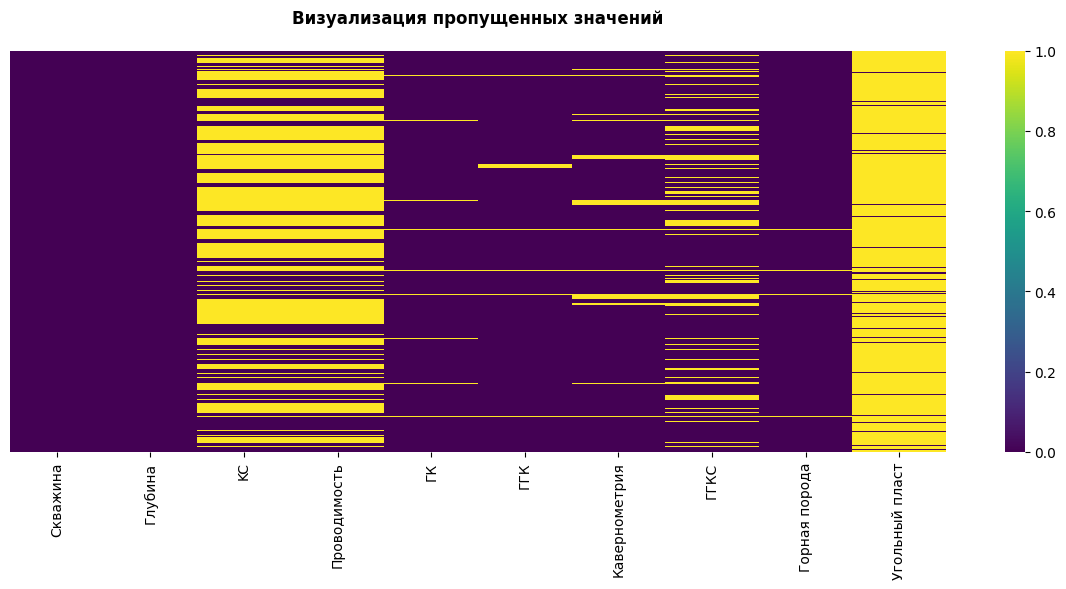

In [ ]:
# Анализ пропущенных значений
print("\nАнализ пропущенных значений:")
print("-" * 50)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Пропущено': missing_data,
    'Процент': missing_percent
})
print(missing_info.round(2))

# Визуализация
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Визуализация пропущенных значений', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
# Статистический анализ
print("\nСтатистический анализ")
print("-" * 50)
numeric_columns = ['ГК', 'ГГК', 'Кавернометрия', 'ГГКС', 'KC', 'Проводимость', 'Глубина']
numeric_columns = [col for col in numeric_columns if col in df.columns]

stats_df = df[numeric_columns].describe().T
stats_df['IQR'] = stats_df['75%'] - stats_df['25%']
stats_df['Коэфф_вариации'] = (stats_df['std'] / stats_df['mean']).round(3)
print(stats_df.round(3))


Статистический анализ
--------------------------------------------------
                  count       mean        std    min        25%        50%  \
ГК             651728.0      2.980    696.434 -0.053      0.736      0.953   
ГГК            645232.0      0.141      0.090  0.000      0.100      0.112   
Кавернометрия  622766.0     79.556     16.017  0.000     76.063     77.260   
ГГКС           517561.0  31015.238  48775.939  0.000  11000.000  15600.000   
KC             281374.0    184.174   2339.814  0.000     19.562     27.769   
Проводимость   281328.0      0.207      9.453  0.000      0.022      0.036   
Глубина        660004.0    191.245    115.659 -2.200     91.587    188.400   

                     75%         max        IQR  Коэфф_вариации  
ГК                 1.124  298209.160      0.388         233.718  
ГГК                0.146       1.631      0.047           0.642  
Кавернометрия     78.936     481.488      2.873           0.201  
ГГКС           23700.000  322100.000 

- count - Количество непустых (валидных) измерений для каждого параметра.
- mean - Среднее арифметическое значение.
- std - Стандартное отклонение от среднего значения (разброс данных).
- min - Минимальное зафиксированное значение.
- 25% - Первый квартиль. Значение, ниже которого находятся 25% всех данных.
- 50% - Медиана. 50% данных лежат ниже этого значения, 50% — выше.
- 75% - Третий квартиль. Значение, ниже которого находятся 75% всех данных.
- max - Максимальное зафиксированное значение.
- IQR - Межквартильный размах. Рассчитывается как IQR = 75% - 25%.
- Коэфф_вариации - Коэффициент вариации. Рассчитывается как (std / mean) * 100%. Показывает относительную изменчивость данных, независимо от их единиц измерения.

In [ ]:
# Анализ выбросов
print("\nАнализ выбросов")
print("-" * 50)

def detect_outliers_iqr(data, column):
    """Обнаружение выбросов методом IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers_info = []
for col in numeric_columns:
    if col != 'Глубина':  # Глубину не анализируем на выбросы
        outliers, lower, upper = detect_outliers_iqr(df, col)
        outlier_percent = (len(outliers) / len(df)) * 100
        outliers_info.append({
            'Параметр': col,
            'Выбросы': len(outliers),
            'Процент': outlier_percent,
            'Нижняя_граница': lower,
            'Верхняя_граница': upper
        })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df.round(3))


Анализ выбросов
--------------------------------------------------
        Параметр  Выбросы  Процент  Нижняя_граница  Верхняя_граница
0             ГК    14968    2.268           0.154            1.705
1            ГГК    76686   11.619           0.029            0.217
2  Кавернометрия    93133   14.111          71.753           83.247
3           ГГКС    66297   10.045       -8050.000        42750.000
4             KC    32675    4.951         -19.663           84.937
5   Проводимость    15549    2.356          -0.022            0.095


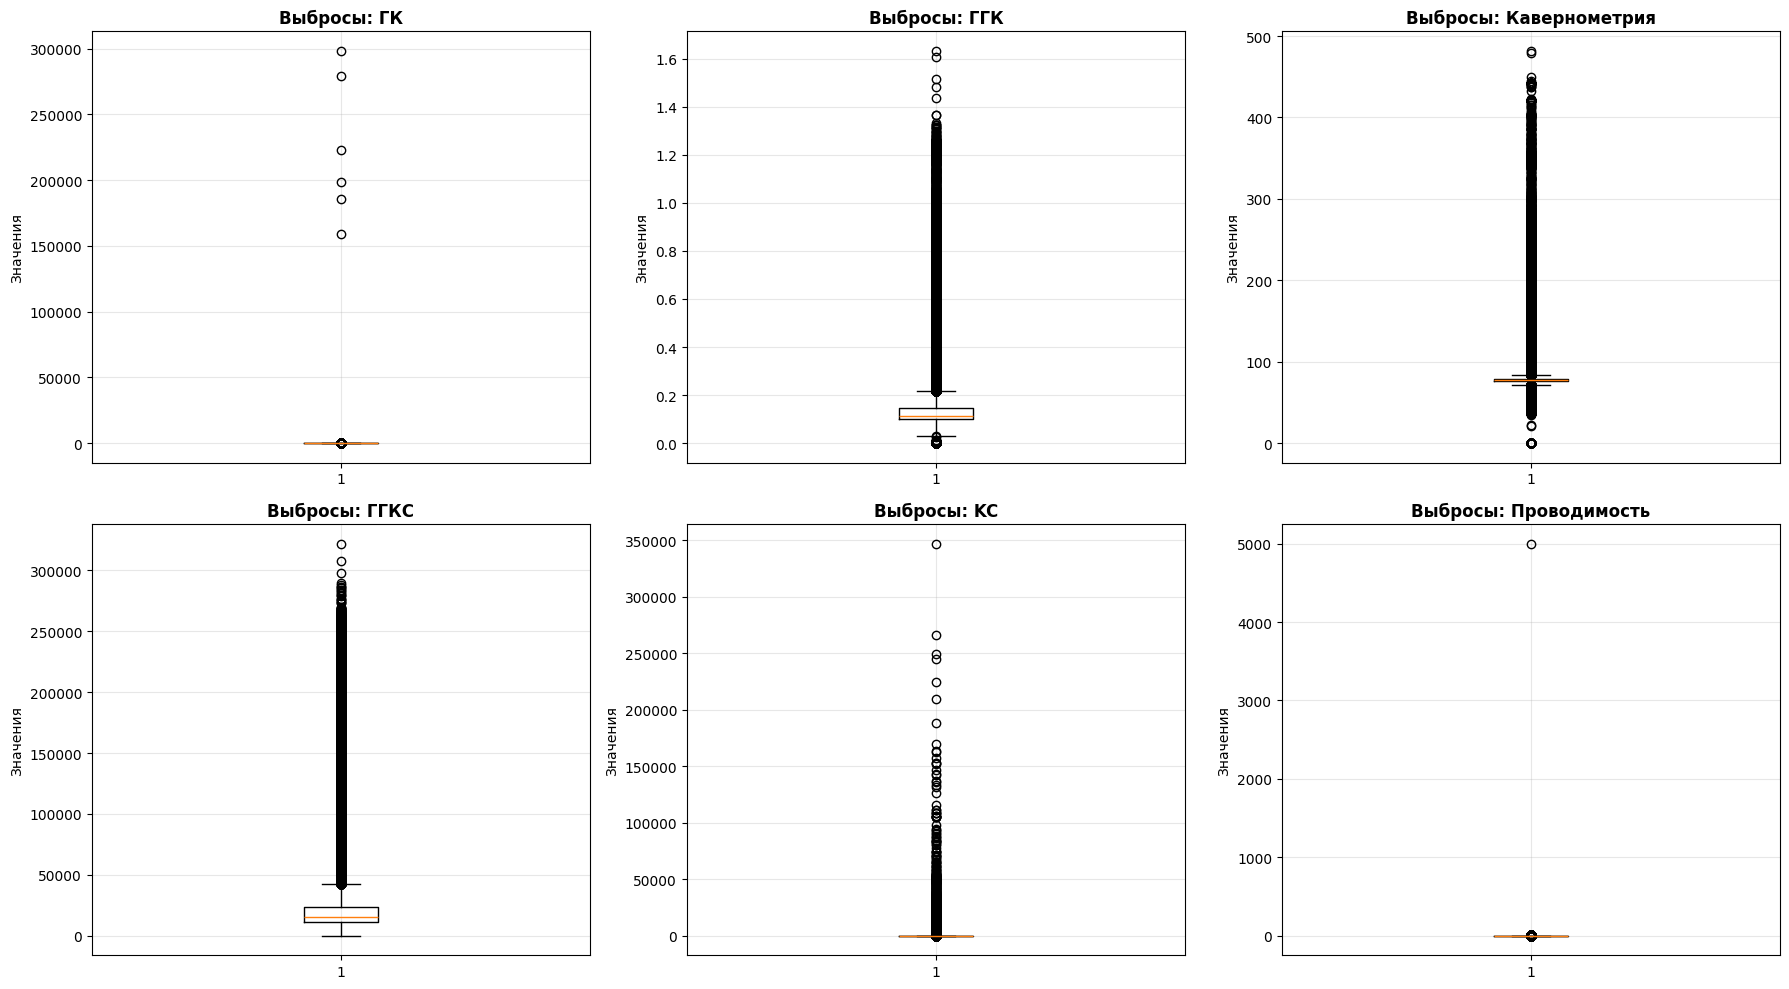

In [ ]:
# Визуализация выбрасов
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_columns[:6]):  # Первые 6 параметров
    if col in df.columns:
        # Boxplot для визуализации выбросов
        df_boxplot = df[[col]].dropna()
        if len(df_boxplot) > 0:
            axes[i].boxplot(df_boxplot[col])
            axes[i].set_title(f'Выбросы: {col}', fontweight='bold')
            axes[i].set_ylabel('Значения')
            axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Анализ распределения параметров
--------------------------------------------------


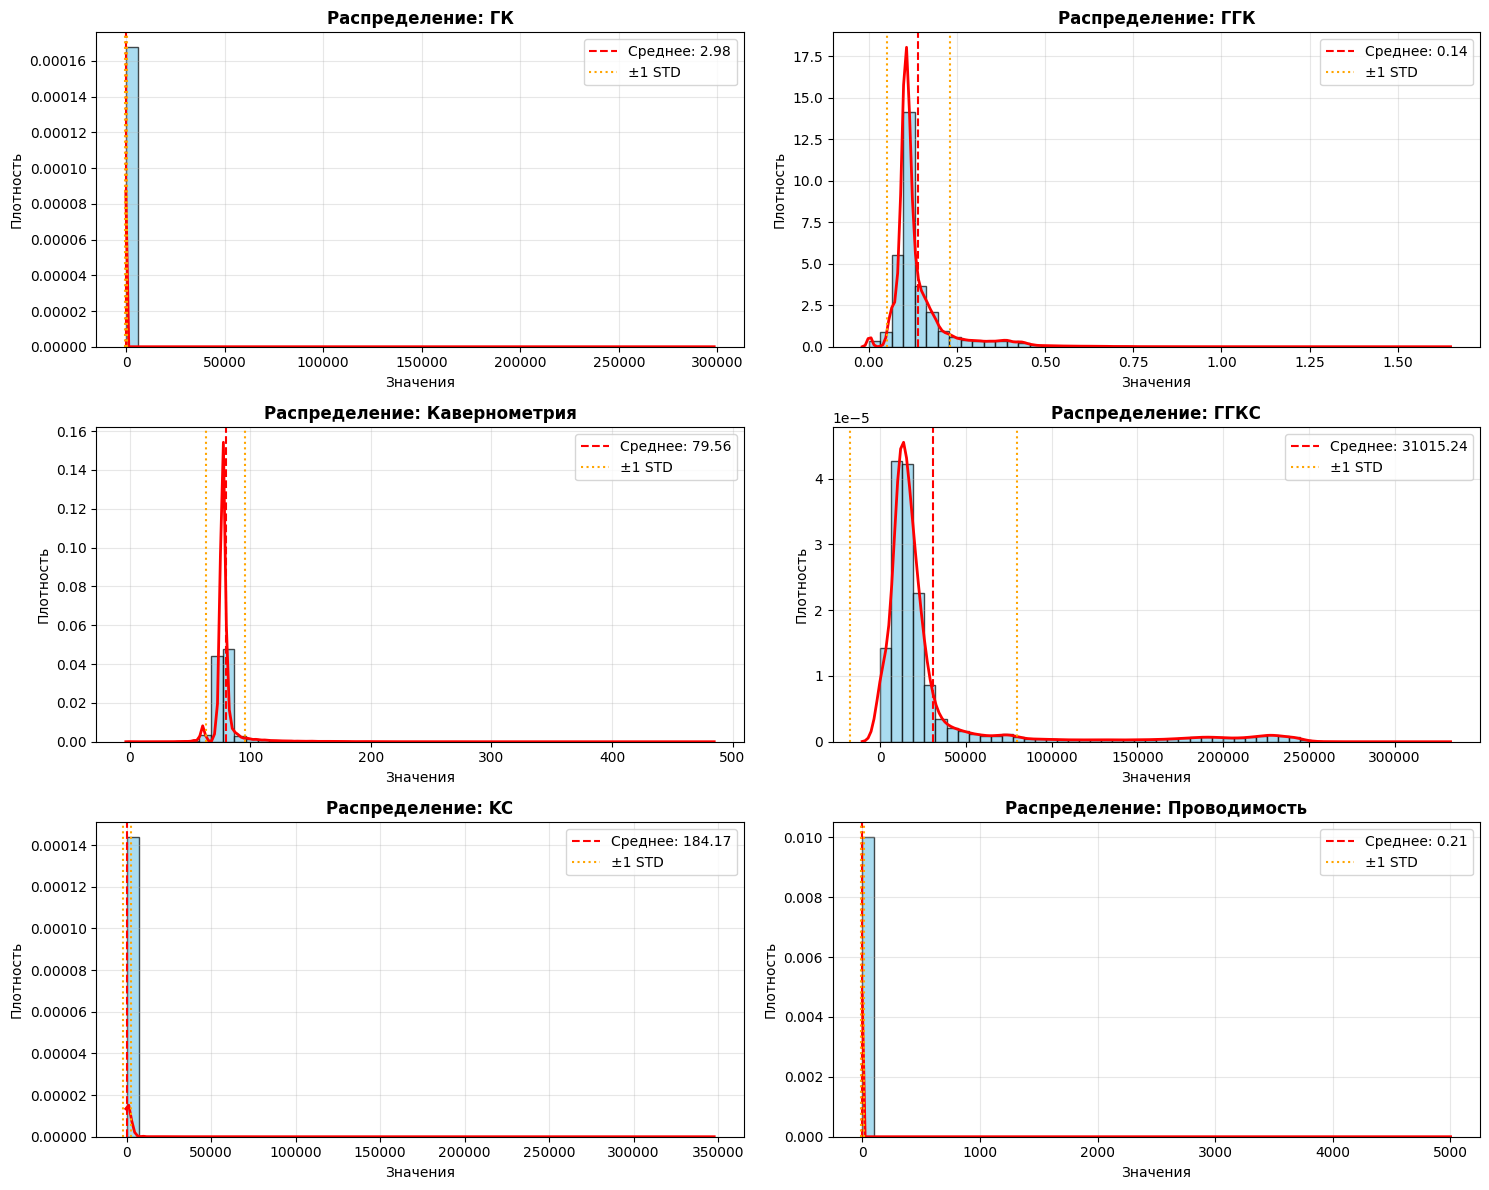

In [ ]:
# Анализ распределения параметров
print("\nАнализ распределения параметров")
print("-" * 50)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_columns[:6]):
    if col in df.columns:
        data = df[col].dropna()
        if len(data) > 0:
            # Гистограмма с KDE
            axes[i].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)

            # KDE plot
            sns.kdeplot(data, ax=axes[i], color='red', linewidth=2)

            axes[i].set_title(f'Распределение: {col}', fontweight='bold')
            axes[i].set_xlabel('Значения')
            axes[i].set_ylabel('Плотность')
            axes[i].grid(True, alpha=0.3)

            # Cтатистики
            mean_val = data.mean()
            std_val = data.std()
            axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.2f}')
            axes[i].axvline(mean_val + std_val, color='orange', linestyle=':', label='±1 STD')
            axes[i].axvline(mean_val - std_val, color='orange', linestyle=':')
            axes[i].legend()

plt.tight_layout()
plt.show()


Матрица корреляций:
--------------------------------------------------


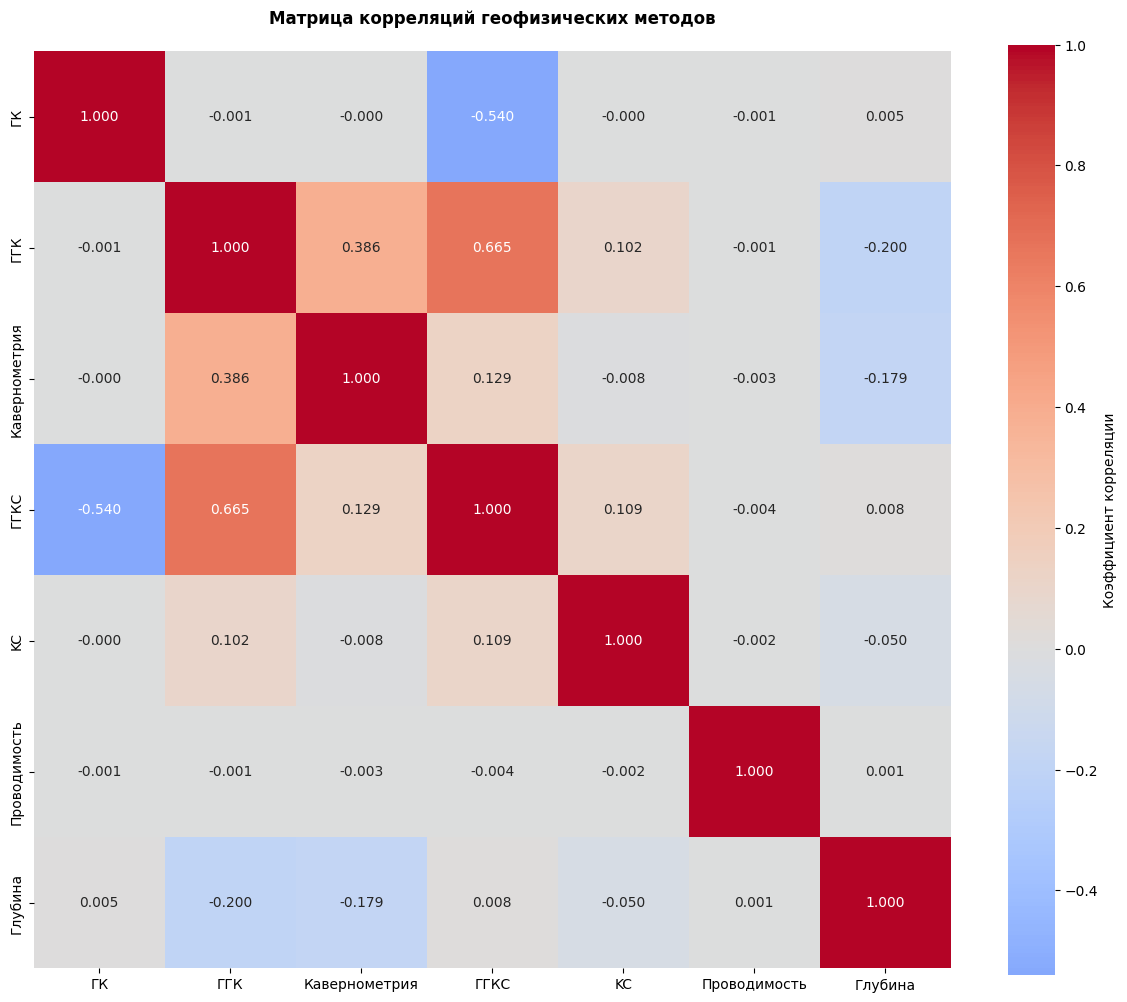

In [ ]:
# Анализ корреляций
print("\nМатрица корреляций:")
print("-" * 50)

# Вычисляем корреляционную матрицу
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Коэффициент корреляции'})

plt.title('Матрица корреляций геофизических методов', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


Анализ данных литологии:
--------------------------------------------------
Распределение литологии:
Горная порода
Алевролит мелкозернистый(VI)                  240556
Переслаивание алевролита и песчаника(VIII)    111770
Песчаник мелкозернистый(VIII)                  71275
Песчаник среднезернистый(VIII)                 64662
Переслаивание алевролитовых разностей(VII)     38542
Уголь(IV)                                      36778
Алевролит крупнозернистый(VII)                 33441
Суглинок(III)                                  20398
Песчаник крупнозернистый(VIII)                 19122
Алевролит углистый(IV)                          6768
Name: count, dtype: int64


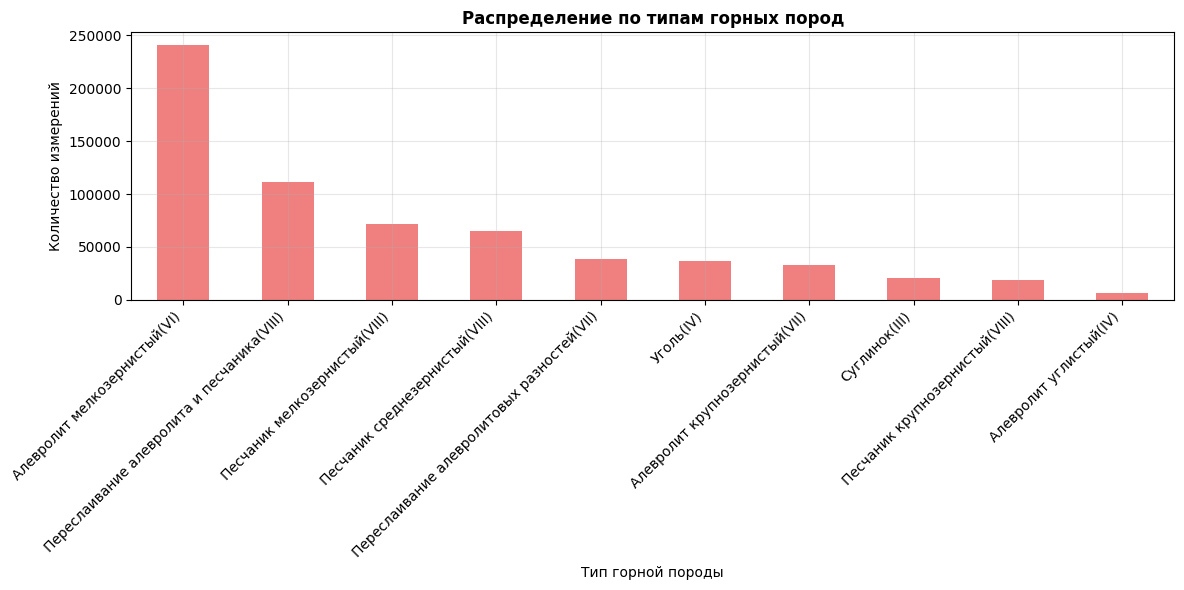

In [ ]:
# Анализ данных литологии
print("\nАнализ данных литологии:")
print("-" * 50)

if 'Горная порода' in df.columns:
    lithology_counts = df['Горная порода'].value_counts()
    print("Распределение литологии:")
    print(lithology_counts.head(10)) # возьмем 10 основных

    # Визуализация распределения литологии
    plt.figure(figsize=(12, 6))
    lithology_counts.head(10).plot(kind='bar', color='lightcoral')
    plt.title('Распределение по типам горных пород', fontweight='bold')
    plt.xlabel('Тип горной породы')
    plt.ylabel('Количество измерений')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Анализ каротажных кривых по глубине:
--------------------------------------------------


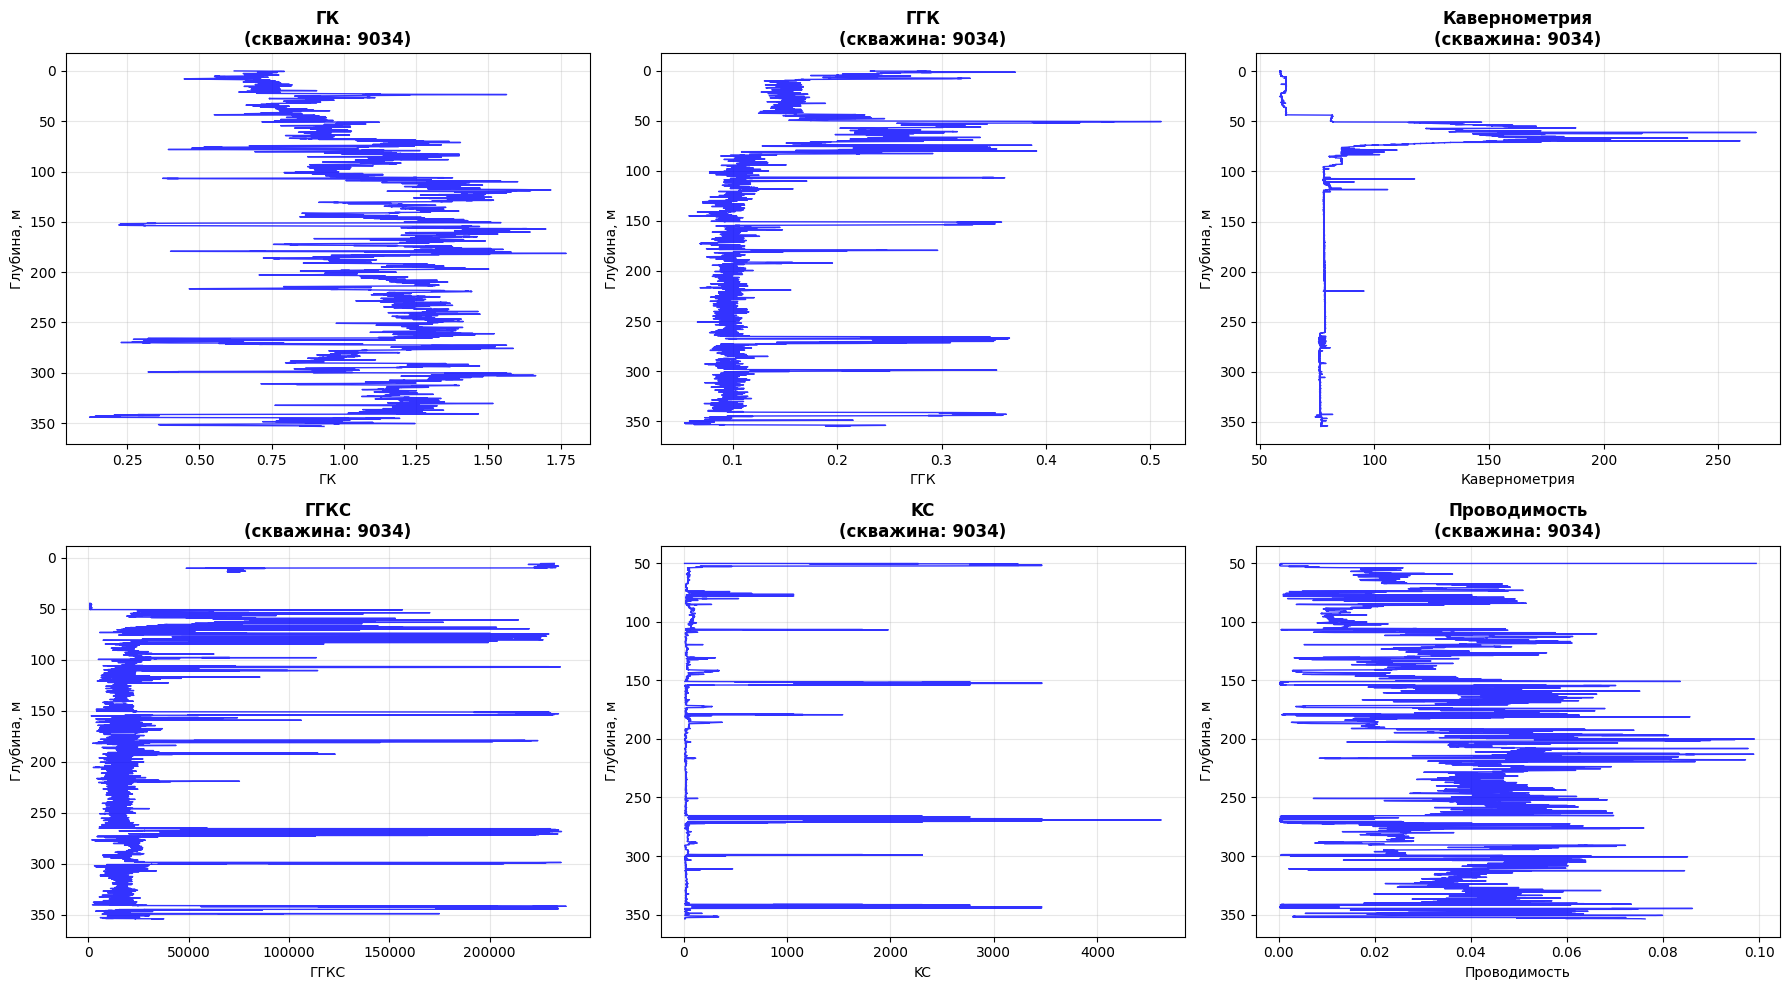

In [ ]:
# Анализ каротажных кривых
print("\nАнализ каротажных кривых по глубине:")
print("-" * 50)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_columns[:6]):
    if col in df.columns and col != 'Глубина':
        # Выбираем случайную скважину для примера
        well_sample = df['Скважина'].iloc[0] if len(df) > 0 else None
        well_data = df[df['Скважина'] == well_sample].sort_values('Глубина')

        if len(well_data) > 0:
            axes[i].plot(well_data[col], well_data['Глубина'],
            linewidth=1, alpha=0.8, color='blue')
            axes[i].set_title(f'{col}\n(скважина: {well_sample})', fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Глубина, м')
            axes[i].grid(True, alpha=0.3)
            axes[i].invert_yaxis()

plt.tight_layout()
plt.show()


### Обработка выбросов
- IQR метод - если выбросов менее 10% и их можно удалить
- Winsorization - при умеренном количестве выбросов
- Z-score - эффективен для нормально распределенных данных
- Robust метод - самый безопасный, сохраняет все данные

In [ ]:
# Метод IQR (межквартильный размах)
def remove_outliers_iqr(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Удаление выбросов методом IQR
    """
    df_clean = df.copy()
    initial_size = len(df_clean)

    for col in columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Удаляем выбросы
            mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
            df_clean = df_clean[mask]

    removed_count = initial_size - len(df_clean)
    print(f"Удалено {removed_count} выбросов методом IQR")
    return df_clean

In [ ]:
# Winsorization (ограничение выбросов)
def winsorize_outliers(df: pd.DataFrame, columns: list, limits: tuple=(0.05, 0.05)) -> pd.DataFrame:
    """
    Winsorization - ограничение выбросов вместо удаления
    """
    df_winsorized = df.copy()

    for col in columns:
        if col in df_winsorized.columns:
            # Winsorize только не-NaN значения
            non_null_mask = df_winsorized[col].notna()
            if non_null_mask.any():
                try:
                    winsorized_values = winsorize(
                        df_winsorized.loc[non_null_mask, col], limits=limits
                    )
                    df_winsorized.loc[non_null_mask, col] = winsorized_values
                except Exception as e:
                    print(f"Ошибка при winsorize для {col}: {e}")
                    continue

    print("Выбросы ограничены методом Winsorization")
    return df_winsorized

In [ ]:
# Z-score метод
def remove_outliers_zscore(df: pd.DataFrame, columns: list, threshold: int=3) -> pd.DataFrame:
    """
    Удаление выбросов по Z-score
    """
    df_clean = df.copy()
    initial_size = len(df_clean)

    for col in columns:
        if col in df_clean.columns:
            # Используем только не-NaN значения для расчета
            non_null_mask = df_clean[col].notna()
            if non_null_mask.any():
                col_data = df_clean.loc[non_null_mask, col]
                z_scores = np.abs((col_data - col_data.mean()) / col_data.std())
                mask = z_scores <= threshold

                # Обновляем маску для всего датафрейма
                final_mask = non_null_mask.copy()
                final_mask[non_null_mask] = mask
                df_clean = df_clean[final_mask]

    removed_count = initial_size - len(df_clean)
    print(f"Удалено {removed_count} выбросов (Z-score метод)")
    return df_clean

In [ ]:
# Robust Scaler + IQR комбинированный подход
def robust_scale_and_filter(df: pd.DataFrame, columns: list):
    """
    Комбинированный подход: Robust scaling + фильтрация выбросов
    """
    df_processed = df.copy()
    initial_size = len(df_processed)

    for col in columns:
        if col in df_processed.columns:
            # Robust scaling (устойчив к выбросам)
            scaler = RobustScaler()
            non_null_mask = df_processed[col].notna()

            if non_null_mask.sum() > 0:
                try:
                    scaled_values = scaler.fit_transform(
                        df_processed.loc[non_null_mask, col].values.reshape(-1, 1)
                    ).flatten()

                    # Фильтрация после scaling
                    mask = (scaled_values >= -3) & (scaled_values <= 3)
                    final_mask = non_null_mask.copy()
                    final_mask[non_null_mask] = mask

                    df_processed = df_processed[final_mask]
                except Exception as e:
                    print(f"Ошибка при обработке {col}: {e}")
                    continue

    removed_count = initial_size - len(df_processed)
    print(f"Обработано выбросов Robust методом. Удалено: {removed_count}")
    return df_processed

In [ ]:
# Обработка выбросов
print("Обработка выбросов")
print("-"*50)

# Столбцы для обработки выбросов
outlier_columns = ['ГК', 'ГГК', 'Кавернометрия', 'ГГКС', 'KC', 'Проводимость']
outlier_columns = [col for col in outlier_columns if col in df.columns]

print(f"Размер датасета до обработки выбросов: {len(df)}")

# Анализ выбросов перед обработкой
print("\nАнализ выбросов до обработки:")
outlier_info = []
for col in outlier_columns:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outliers_percent = (outliers_count / len(df)) * 100

        print(f"{col}: {outliers_count} выбросов ({outliers_percent:.1f}%)")
        outlier_info.append({
            'column': col,
            'outliers_count': outliers_count,
            'outliers_percent': outliers_percent
        })

Обработка выбросов
--------------------------------------------------
Размер датасета до обработки выбросов: 660004

Анализ выбросов до обработки:
ГК: 14968 выбросов (2.3%)
ГГК: 76686 выбросов (11.6%)
Кавернометрия: 93133 выбросов (14.1%)
ГГКС: 66297 выбросов (10.0%)
KC: 32675 выбросов (5.0%)
Проводимость: 15549 выбросов (2.4%)


In [ ]:
# Автоматический алгоритм выбора метода для обработки выбросов (по количеству в %)
total_outliers_percent = sum(info['outliers_percent'] for info in outlier_info) / len(outlier_info)

if total_outliers_percent < 5:
    method = "iqr"
elif total_outliers_percent < 20:
    method = "winsorize"
else:
    method = "robust"

print(f"\nАвтоматически выбран метод: {method} (средний процент выбросов: {total_outliers_percent:.1f}%)")

# Применяем выбранный метод
if method == "iqr":
    df_clean = remove_outliers_iqr(df, outlier_columns)
elif method == "winsorize":
    df_clean = winsorize_outliers(df, outlier_columns, limits=(0.05, 0.05))
elif method == "zscore":
    df_clean = remove_outliers_zscore(df, outlier_columns, threshold=3)
elif method == "robust":
    df_clean = robust_scale_and_filter(df, outlier_columns)

print(f"Размер датасета после обработки выбросов: {len(df_clean)}")


Автоматически выбран метод: winsorize (средний процент выбросов: 7.6%)
Выбросы ограничены методом Winsorization
Размер датасета после обработки выбросов: 660004


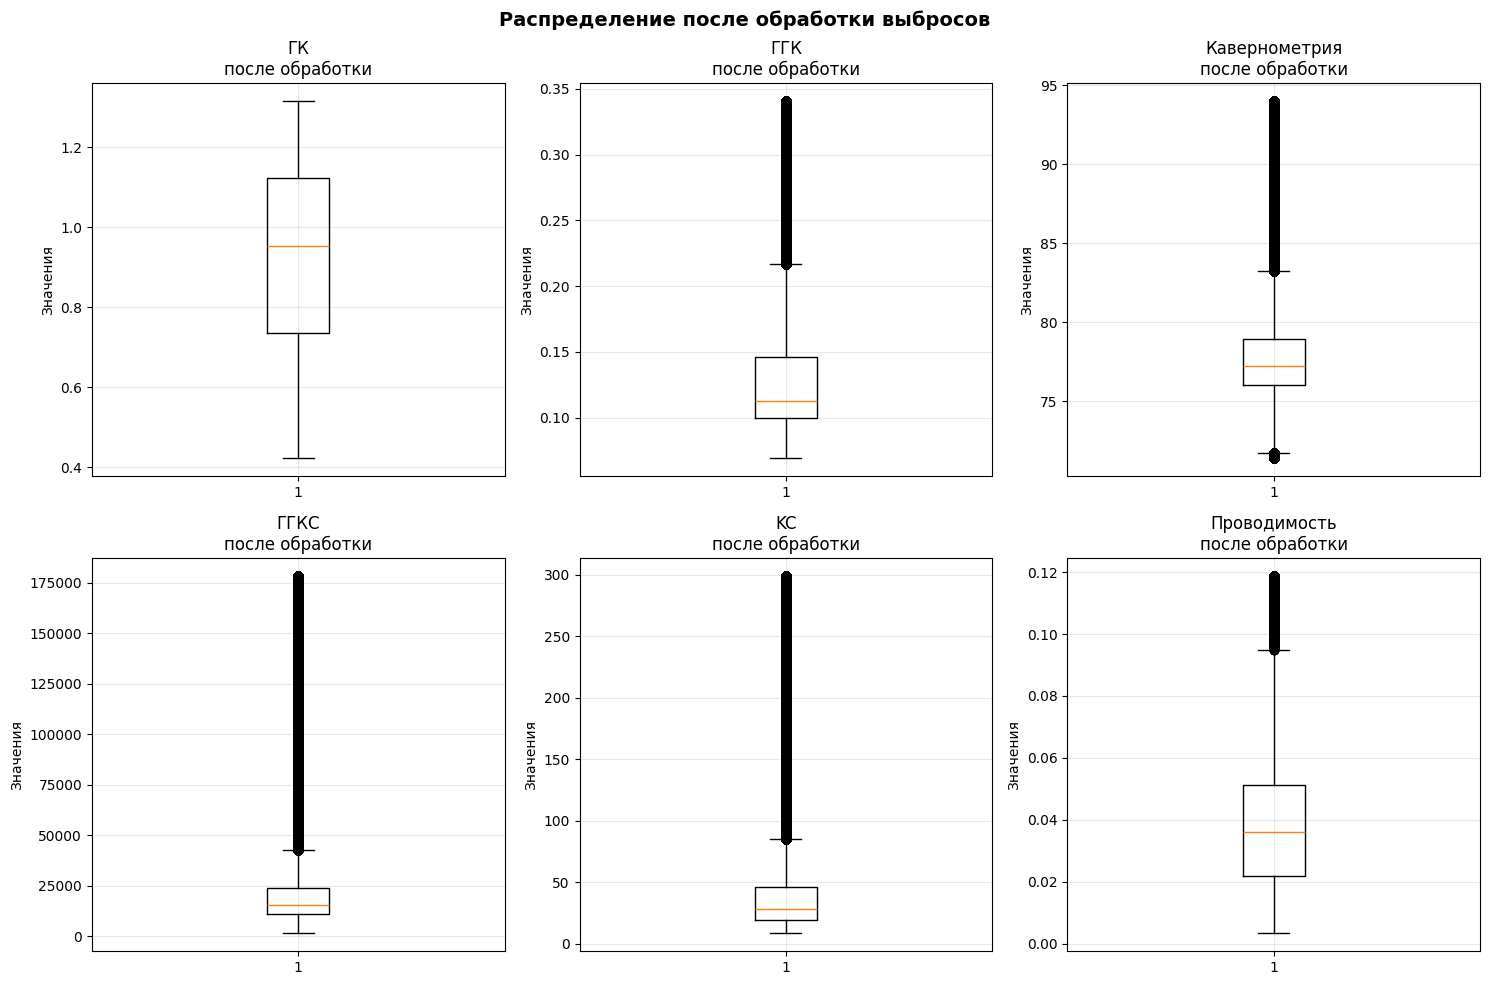

In [ ]:
# Визуализация результатов
if len(outlier_columns) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, col in enumerate(outlier_columns[:6]):  # Первые 6 параметров
        if col in df_clean.columns:
            # Boxplot после обработки
            data_clean = df_clean[col].dropna()
            if len(data_clean) > 0:
                axes[i].boxplot(data_clean)
                axes[i].set_title(f'{col}\nпосле обработки')
                axes[i].set_ylabel('Значения')
                axes[i].grid(True, alpha=0.3)

    # Скрываем пустые subplots
    for i in range(len(outlier_columns), 6):
        axes[i].set_visible(False)

    plt.suptitle('Распределение после обработки выбросов', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
# Сравнение статистик до и после обработки
print("\nСравнение статистик:")
print("="*50)
for col in outlier_columns[:6]:
    if col in df.columns and col in df_clean.columns:
        print(f"\n{col}:")
        print(f"  До: min={df[col].min():.2f}, max={df[col].max():.2f}, std={df[col].std():.2f}")
        print(f"  После: min={df_clean[col].min():.2f}, max={df_clean[col].max():.2f}, std={df_clean[col].std():.2f}")

# Обновляем основной датафрейм
df = df_clean
print(f"\nФинальный размер датасета: {len(df)} записей")


Сравнение статистик:

ГК:
  До: min=-0.05, max=298209.16, std=696.43
  После: min=0.42, max=1.32, std=0.25

ГГК:
  До: min=0.00, max=1.63, std=0.09
  После: min=0.07, max=0.34, std=0.07

Кавернометрия:
  До: min=0.00, max=481.49, std=16.02
  После: min=71.41, max=94.01, std=4.83

ГГКС:
  До: min=0.00, max=322100.00, std=48775.94
  После: min=1300.00, max=178200.00, std=41800.00

KC:
  До: min=0.00, max=347169.06, std=2339.81
  После: min=8.32, max=298.97, std=65.75

Проводимость:
  До: min=0.00, max=5000.00, std=9.45
  После: min=0.00, max=0.12, std=0.03

Финальный размер датасета: 660004 записей


## Дополнительная обработка
**Обработка отрицательных глубин и пропущенных значений**

In [ ]:
# Удаление строк с отрицательной глубиной
df = df[df['Глубина'] >= 0]

# Анализ пропущенных значений
print("Пропущенные значения после фильтрации:")
print(df.isnull().sum())


Пропущенные значения после фильтрации:
Скважина               0
Глубина                0
KC                     0
Проводимость           0
ГК                     0
ГГК                    0
Кавернометрия          0
ГГКС                   0
Горная порода         36
Угольный пласт    611367
dtype: int64


In [ ]:
# Проверка уникальных значений литологии
print("\nУникальные типы горных пород:")
print(df['Горная порода'].value_counts())
print("\nУникальные угольные пласты:")
print(df['Угольный пласт'].value_counts())


Уникальные типы горных пород:
Горная порода
Алевролит мелкозернистый(VI)                   240556
Переслаивание алевролита и песчаника(VIII)     111770
Песчаник мелкозернистый(VIII)                   71275
Песчаник среднезернистый(VIII)                  64662
Переслаивание алевролитовых разностей(VII)      38542
Уголь(IV)                                       36778
Алевролит крупнозернистый(VII)                  33441
Суглинок(III)                                   20398
Песчаник крупнозернистый(VIII)                  19122
Алевролит углистый(IV)                           6768
Алевролит среднезернистый(VI)                    5030
Аргиллит(VI)                                     1755
Глина(III)                                       1470
Почвенно-растительный слой(I)                    1453
Супесь(III)                                      1359
Конгломерат(IX)                                   593
Гравелит(IX)                                      387
Переслаивание песчаника и алевролита 

In [ ]:
# Удаляем строки, где в горной породе указан угольный пласт
df = df[~df['Горная порода'].str.contains('Сычевский', na=False)]

# Убираем кавычки и лишние точки из наименований угольных пластов
df['Угольный пласт'] = df['Угольный пласт'].str.replace('"', '')  # Убираем кавычки
df['Угольный пласт'] = df['Угольный пласт'].str.replace(r'\.+', '.', regex=True)  # Убираем лишние точки
df['Угольный пласт'] = df['Угольный пласт'].str.strip()  # Убираем пробелы по краям

# Убираем пласты, обозначенные одним числом
df = df[~df['Угольный пласт'].astype(str).str.match(r'^\d+$')]

# Проверяем результат
print(f"Уникальных типов горных пород после очистки: {df['Горная порода'].nunique()}")
print(df['Горная порода'].value_counts())

print(f"\nУникальных названий после очистки: {df['Угольный пласт'].nunique()}")
print(df['Угольный пласт'].value_counts().head(15))

Уникальных типов горных пород после очистки: 26
Горная порода
Алевролит мелкозернистый(VI)                   239712
Переслаивание алевролита и песчаника(VIII)     111770
Песчаник мелкозернистый(VIII)                   71275
Песчаник среднезернистый(VIII)                  64662
Переслаивание алевролитовых разностей(VII)      38542
Уголь(IV)                                       36778
Алевролит крупнозернистый(VII)                  33441
Суглинок(III)                                   20398
Песчаник крупнозернистый(VIII)                  19122
Алевролит углистый(IV)                           6768
Алевролит среднезернистый(VI)                    5030
Аргиллит(VI)                                     1755
Глина(III)                                       1470
Почвенно-растительный слой(I)                    1453
Супесь(III)                                      1359
Конгломерат(IX)                                   593
Гравелит(IX)                                      387
Переслаивание песчан

**Нормализация геофизических данных в диапазон 0-1**

In [ ]:
# Нормализация геофизических данных в диапазон 0-1

# Кривые для нормализации
curves_to_normalize = ['ГК', 'ГГК', 'Кавернометрия', 'ГГКС', 'KC', 'Проводимость']
curves_to_normalize = [col for col in curves_to_normalize if col in df.columns]

print("Нормализация геофизических кривых:\n")

# Создаем копию датафрейма для нормализованных данных
df_normalized = df.copy()

# Нормализуем каждую кривую отдельно в диапазон 0-1
scaler = MinMaxScaler()
for curve in curves_to_normalize:
    # Сохраняем исходные статистики
    original_min = df[curve].min()
    original_max = df[curve].max()
    original_non_null = df[curve].notna().sum()

    # Нормализуем
    non_null_mask = df[curve].notna()
    if non_null_mask.any():
        df_normalized.loc[non_null_mask, f'{curve}_norm'] = scaler.fit_transform(
            df.loc[non_null_mask, curve].values.reshape(-1, 1)
        ).flatten()
    else:
        df_normalized[f'{curve}_norm'] = np.nan

    # Выводим статистику нормализации
    print(f"{curve}:")
    print(f"  Исходный диапазон: {original_min:.2f} - {original_max:.2f}")
    print(f"  Нормализованный: {df_normalized[f'{curve}_norm'].min():.3f} - {df_normalized[f'{curve}_norm'].max():.3f}")
    print(f"  Обработано: {original_non_null} значений")
    print()

Нормализация геофизических кривых:

ГК:
  Исходный диапазон: 0.42 - 1.32
  Нормализованный: 0.000 - 1.000
  Обработано: 655553 значений

ГГК:
  Исходный диапазон: 0.07 - 0.34
  Нормализованный: 0.000 - 1.000
  Обработано: 655553 значений

Кавернометрия:
  Исходный диапазон: 71.41 - 94.01
  Нормализованный: 0.000 - 1.000
  Обработано: 655553 значений

ГГКС:
  Исходный диапазон: 1300.00 - 178200.00
  Нормализованный: 0.000 - 1.000
  Обработано: 655553 значений

KC:
  Исходный диапазон: 8.32 - 298.97
  Нормализованный: 0.000 - 1.000
  Обработано: 655553 значений

Проводимость:
  Исходный диапазон: 0.00 - 0.12
  Нормализованный: 0.000 - 1.000
  Обработано: 655553 значений



/tmp/ipython-input-2346322754.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipython-input-2346322754.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipython-input-2346322754.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipython-input-2346322754.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 

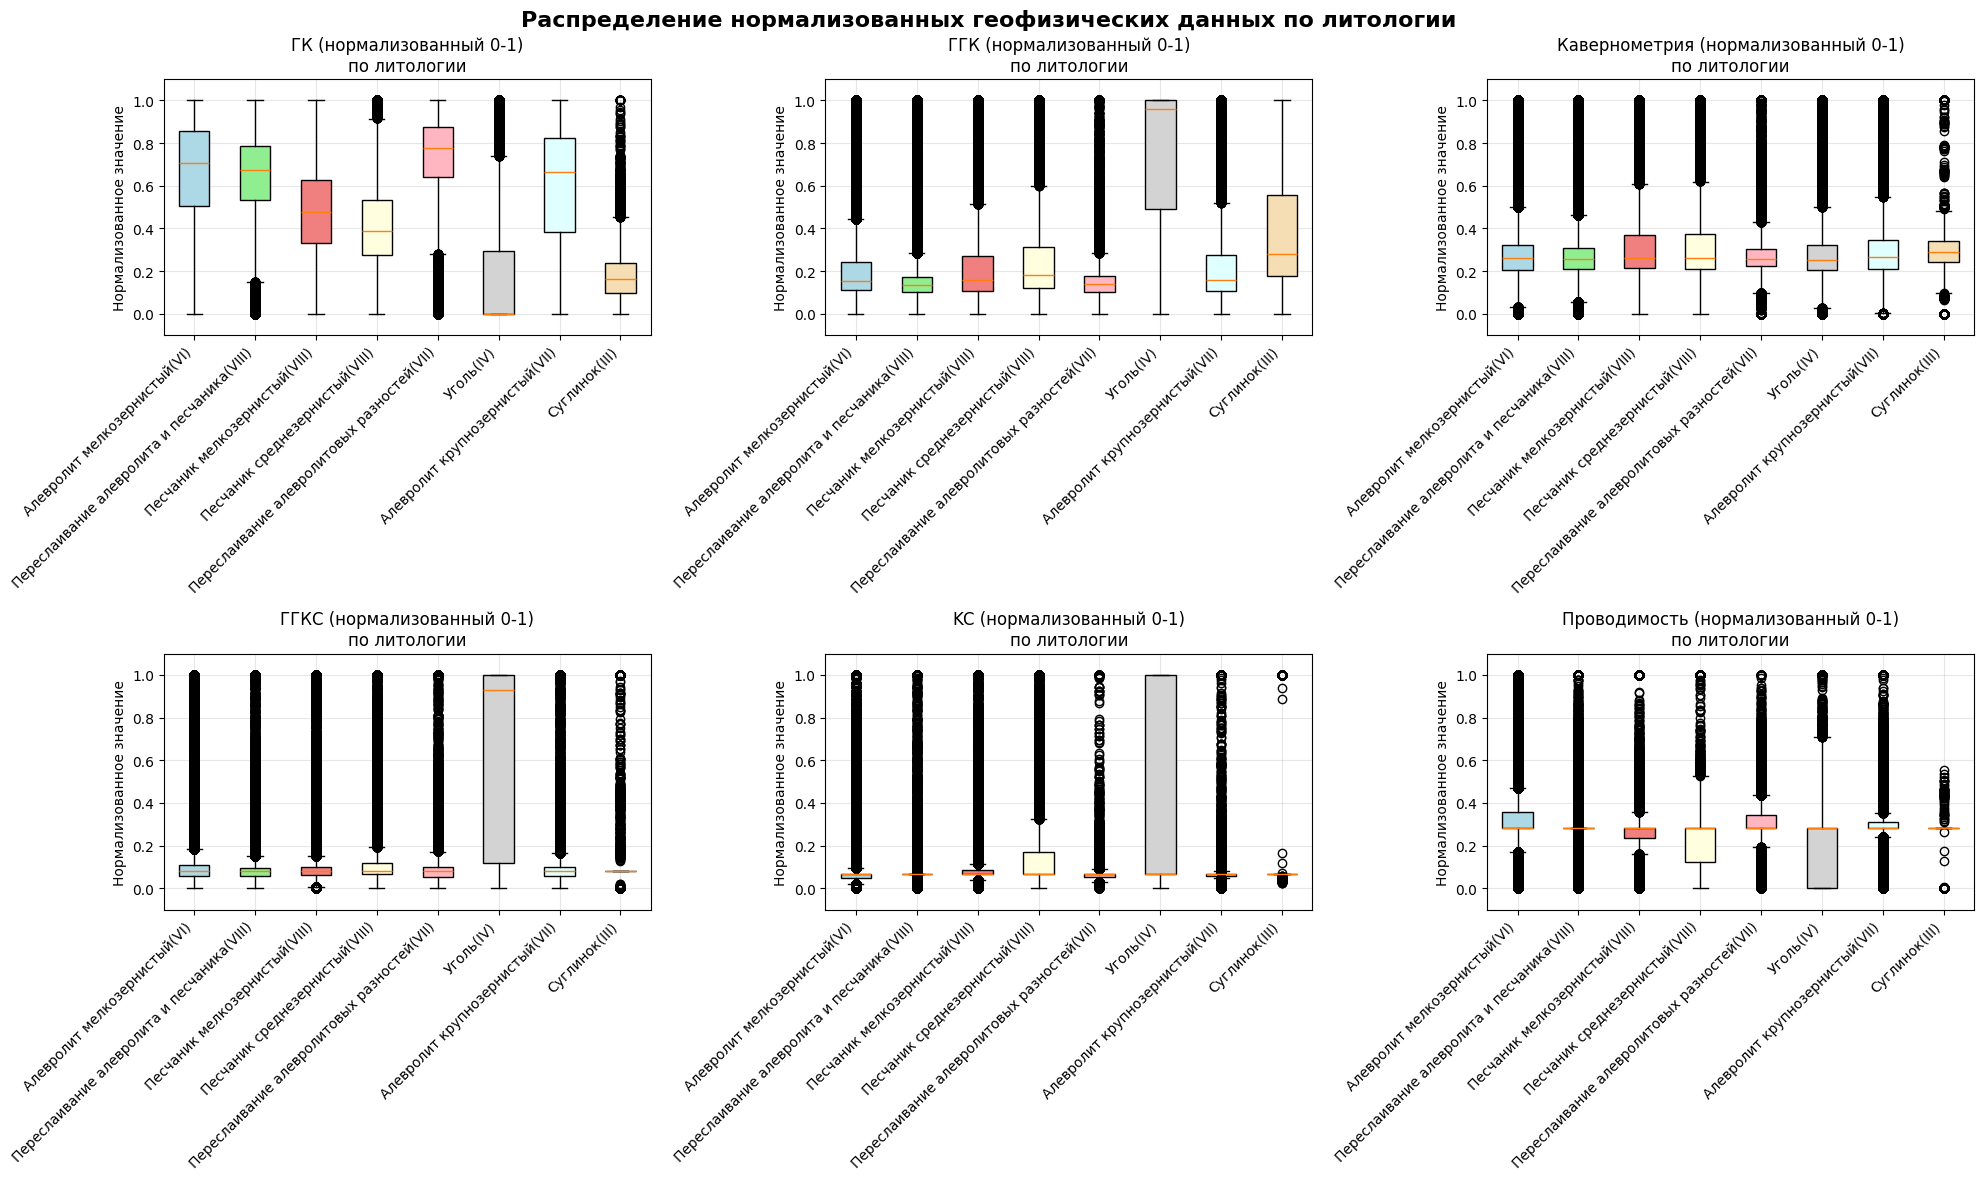

In [ ]:

# Анализ распределения параметров по литологическим типам (нормализованные данные)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

normalized_curves = [f'{curve}_norm' for curve in curves_to_normalize]
top_lithologies = df_normalized['Горная порода'].value_counts().head(8).index

for i, curve_norm in enumerate(normalized_curves):
    if curve_norm in df_normalized.columns:
        # Строим boxplot для основных литологических типов
        data_to_plot = []
        labels = []

        for lith in top_lithologies:
            values = df_normalized[df_normalized['Горная порода'] == lith][curve_norm].dropna()
            if len(values) > 0:
                data_to_plot.append(values)
                labels.append(lith)

        if data_to_plot:
            box_plot = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)

            colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray', 'lightcyan', 'wheat']
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)

            curve_name = curve_norm.replace('_norm', '')
            axes[i].set_title(f'{curve_name} (нормализованный 0-1)\nпо литологии', fontsize=12)
            axes[i].set_xticklabels(labels, rotation=45, ha='right')
            axes[i].set_ylabel('Нормализованное значение')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_ylim(-0.1, 1.1)  # Единый масштаб для всех графиков

# Убираем пустые subplots
for i in range(len(normalized_curves), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Распределение нормализованных геофизических данных по литологии',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



## Дополнительный анализ нормализованных данных

In [ ]:
# Анализ средних значений нормализованных данных
print("\nАнализ средних значений нормализованных данных по литологии:")
print("=" * 70)

# Основные литологические типы для анализа
main_lithologies = ['Уголь', 'Песчаник', 'Алевролит', 'Аргиллит']

for lith_pattern in main_lithologies:
    lith_mask = df_normalized['Горная порода'].str.contains(lith_pattern, na=False)
    if lith_mask.sum() > 0:
        print(f"\n{lith_pattern.upper()}:")
        for curve_norm in normalized_curves:
            if curve_norm in df_normalized.columns:
                values = df_normalized[lith_mask][curve_norm].dropna()
                if len(values) > 0:
                    curve_name = curve_norm.replace('_norm', '')
                    mean_val = values.mean()
                    std_val = values.std()
                    print(f"  {curve_name}: {mean_val:.3f} ± {std_val:.3f}")



Анализ средних значений нормализованных данных по литологии:

УГОЛЬ:
  ГК: 0.178 ± 0.289
  ГГК: 0.741 ± 0.325
  Кавернометрия: 0.299 ± 0.195
  ГГКС: 0.641 ± 0.412
  KC: 0.341 ± 0.412
  Проводимость: 0.209 ± 0.183

ПЕСЧАНИК:
  ГК: 0.435 ± 0.204
  ГГК: 0.233 ± 0.211
  Кавернометрия: 0.349 ± 0.265
  ГГКС: 0.106 ± 0.128
  KC: 0.121 ± 0.135
  Проводимость: 0.245 ± 0.134

АЛЕВРОЛИТ:
  ГК: 0.647 ± 0.265
  ГГК: 0.219 ± 0.203
  Кавернометрия: 0.293 ± 0.195
  ГГКС: 0.124 ± 0.171
  KC: 0.073 ± 0.102
  Проводимость: 0.339 ± 0.168

АРГИЛЛИТ:
  ГК: 0.791 ± 0.220
  ГГК: 0.195 ± 0.157
  Кавернометрия: 0.369 ± 0.162
  ГГКС: 0.098 ± 0.138
  KC: 0.072 ± 0.088
  Проводимость: 0.315 ± 0.113


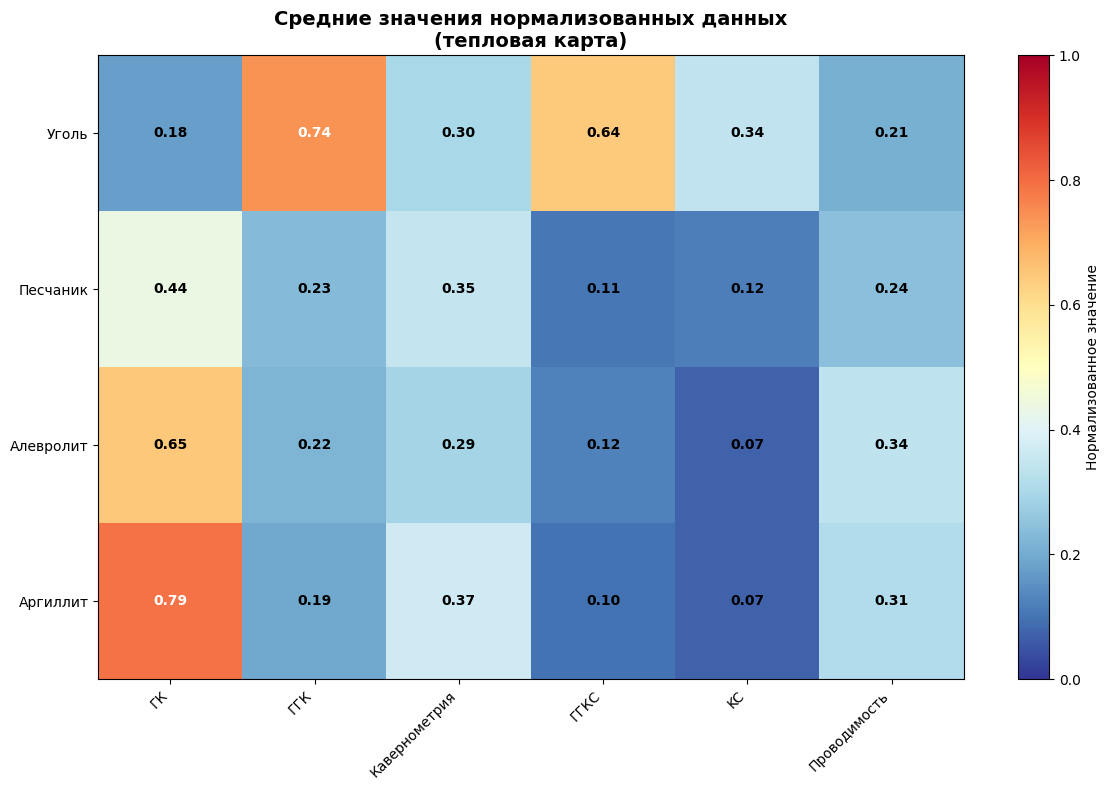

In [ ]:
# Визуализация средних значений
fig, ax = plt.subplots(figsize=(12, 8))

# Подготовка данных для heatmap
heatmap_data = []
lith_labels = []

for lith_pattern in main_lithologies:
    lith_mask = df_normalized['Горная порода'].str.contains(lith_pattern, na=False)
    if lith_mask.sum() > 0:
        lith_means = []
        for curve_norm in normalized_curves:
            if curve_norm in df_normalized.columns:
                values = df_normalized[lith_mask][curve_norm].dropna()
                lith_means.append(values.mean() if len(values) > 0 else 0)
        heatmap_data.append(lith_means)
        lith_labels.append(lith_pattern)

if heatmap_data:
    heatmap_data = np.array(heatmap_data)
    curve_labels = [curve.replace('_norm', '') for curve in normalized_curves]

    im = ax.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

    # Настройки heatmap
    ax.set_xticks(range(len(curve_labels)))
    ax.set_yticks(range(len(lith_labels)))
    ax.set_xticklabels(curve_labels, rotation=45, ha='right')
    ax.set_yticklabels(lith_labels)
    ax.set_title('Средние значения нормализованных данных\n(тепловая карта)',
                 fontsize=14, fontweight='bold')

    # Добавляем значения в ячейки
    for i in range(len(lith_labels)):
        for j in range(len(curve_labels)):
            text = ax.text(j, i, f'{heatmap_data[i, j]:.2f}',
                          ha="center", va="center", color="black" if heatmap_data[i, j] < 0.7 else "white",
                          fontweight='bold')

    plt.colorbar(im, ax=ax, label='Нормализованное значение')
    plt.tight_layout()
    plt.show()

In [ ]:

# Создаем датафрейм для тепловой карты
heatmap_df = pd.DataFrame()

# Берем основные литологические типы
normalized_curves = [f'{curve}_norm' for curve in curves_to_normalize if f'{curve}_norm' in df_normalized.columns]

print("Создание тепловой карты")
print("-" * 50)

# Собираем средние значения
for lith_pattern in main_lithologies:
    lith_mask = df_normalized['Горная порода'].str.contains(lith_pattern, na=False)
    if lith_mask.sum() > 10:  # Не менее 10 samples
        lith_means = {}
        for curve_norm in normalized_curves:
            values = df_normalized[lith_mask][curve_norm].dropna()
            if len(values) > 0:
                curve_name = curve_norm.replace('_norm', '')
                lith_means[curve_name] = values.mean()

        if lith_means:
            heatmap_df[lith_pattern] = pd.Series(lith_means)

# Транспонируем для лучшего отображения
heatmap_df = heatmap_df.T

print("Данные для тепловой карты:")
print(heatmap_df.round(3))

Создание тепловой карты
--------------------------------------------------
Данные для тепловой карты:
              ГК    ГГК  Кавернометрия   ГГКС     KC  Проводимость
Уголь      0.178  0.741          0.299  0.641  0.341         0.209
Песчаник   0.435  0.233          0.349  0.106  0.121         0.245
Алевролит  0.647  0.219          0.293  0.124  0.073         0.339
Аргиллит   0.791  0.195          0.369  0.098  0.072         0.315


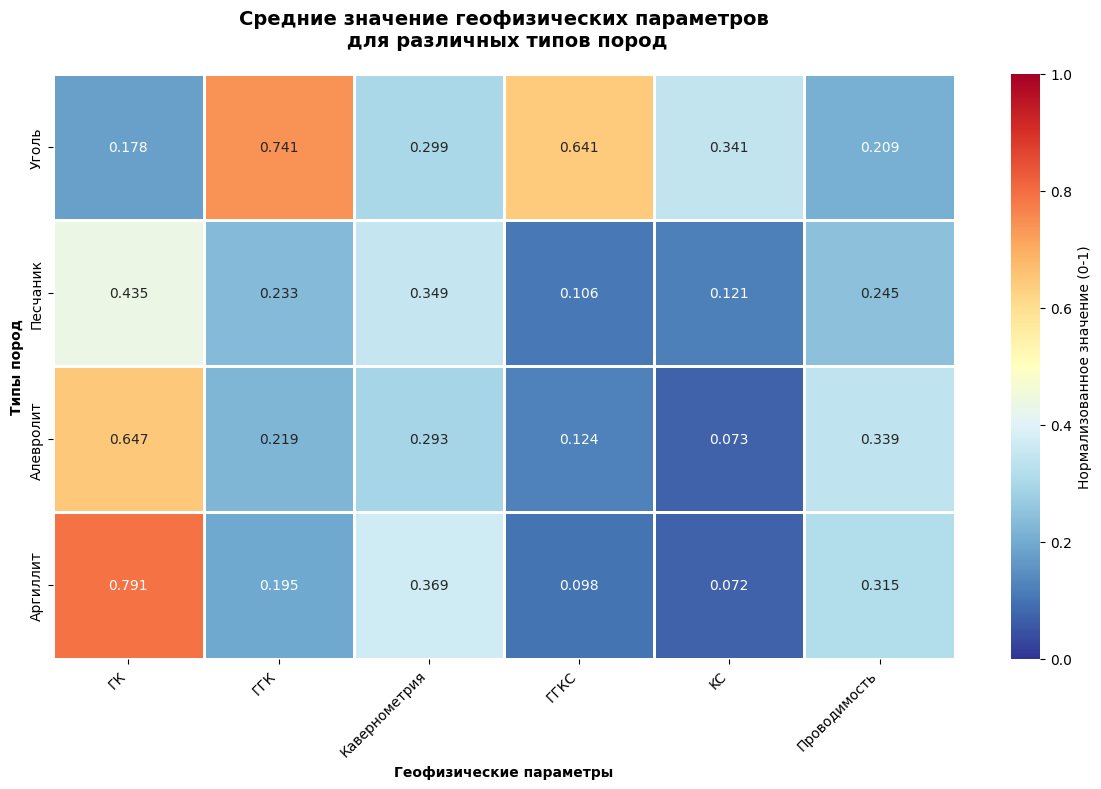

In [ ]:
# Визуализируем тепловую карту
plt.figure(figsize=(12, 8))

ax = sns.heatmap(
    heatmap_df,
    annot=True,          # Показываем числа в ячейках
    fmt='.3f',           # Формат чисел
    cmap='RdYlBu_r',     # Цветовая схема (красный-желтый-синий)
    linewidths=1,        # Линии между ячейками
    linecolor='white',   # Цвет линий
    cbar_kws={'label': 'Нормализованное значение (0-1)'},
    vmin=0, vmax=1       # Фиксируем диапазон
)

plt.title('Средние значение геофизических параметров\n для различных типов вмещающих пород',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Геофизические параметры', fontweight='bold')
plt.ylabel('Типы пород', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Анализ различий между углем и вмещающими породами
--------------------------------------------------


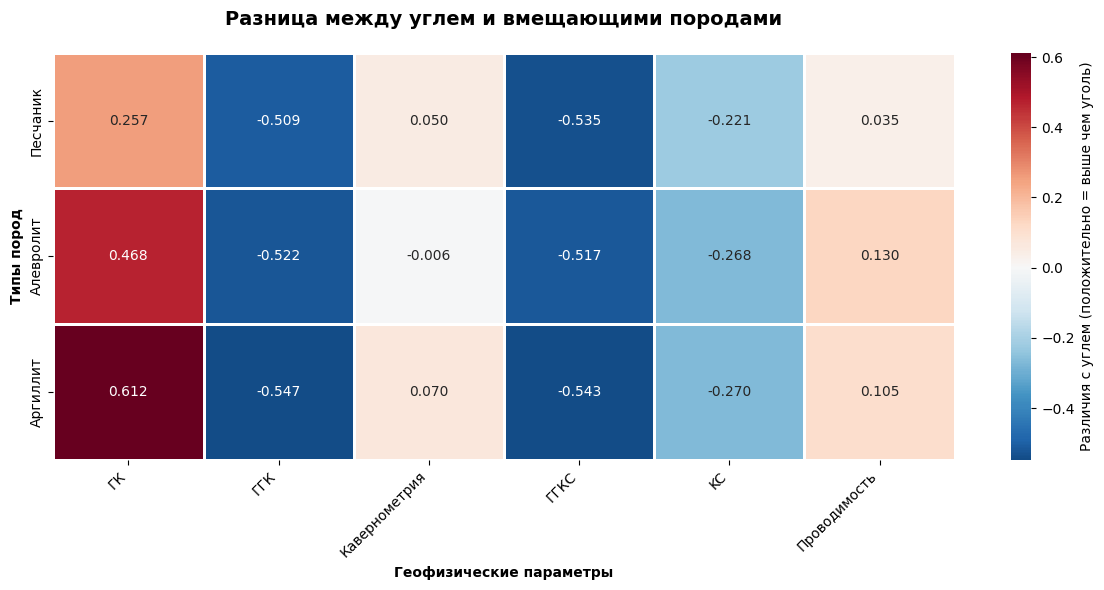

In [ ]:
# Карта различий между углем и вмещающими породами

print("Анализ различий между углем и вмещающими породами")
print("-"*50)

if 'Уголь' in heatmap_df.index:
    coal_values = heatmap_df.loc['Уголь']

    # Считаем разницы с углем
    difference_df = pd.DataFrame()
    for lith in heatmap_df.index:
        if lith != 'Уголь':
            differences = heatmap_df.loc[lith] - coal_values
            difference_df[lith] = differences

    # Визуализируем различия
    plt.figure(figsize=(12, 6))

    ax = sns.heatmap(
        difference_df.T,
        annot=True,
        fmt='.3f',
        cmap='RdBu_r',    # Красно-синяя схема для различий
        center=0,         # Центр в 0
        linewidths=1,
        linecolor='white',
        cbar_kws={'label': 'Различия с углем (положительно = выше чем уголь)'}
    )

    plt.title('Разница между углем и вмещающими породами',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Геофизические параметры', fontweight='bold')
    plt.ylabel('Типы пород', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# Анализ наибольших различий
print("\nНаибольшие различия с улем:")
print("-"*50)
for lith in difference_df.columns:
  max_diff_param = difference_df[lith].abs().idxmax()
  max_diff_value = difference_df[lith][max_diff_param]
  print(f"  {lith}: {max_diff_param} = {max_diff_value:+.3f}")


Наибольшие различия с улем:
--------------------------------------------------
  Песчаник: ГГКС = -0.535
  Алевролит: ГГК = -0.522
  Аргиллит: ГК = +0.612



Сравнение угля с вмещающими породами


<Figure size 1400x800 with 0 Axes>

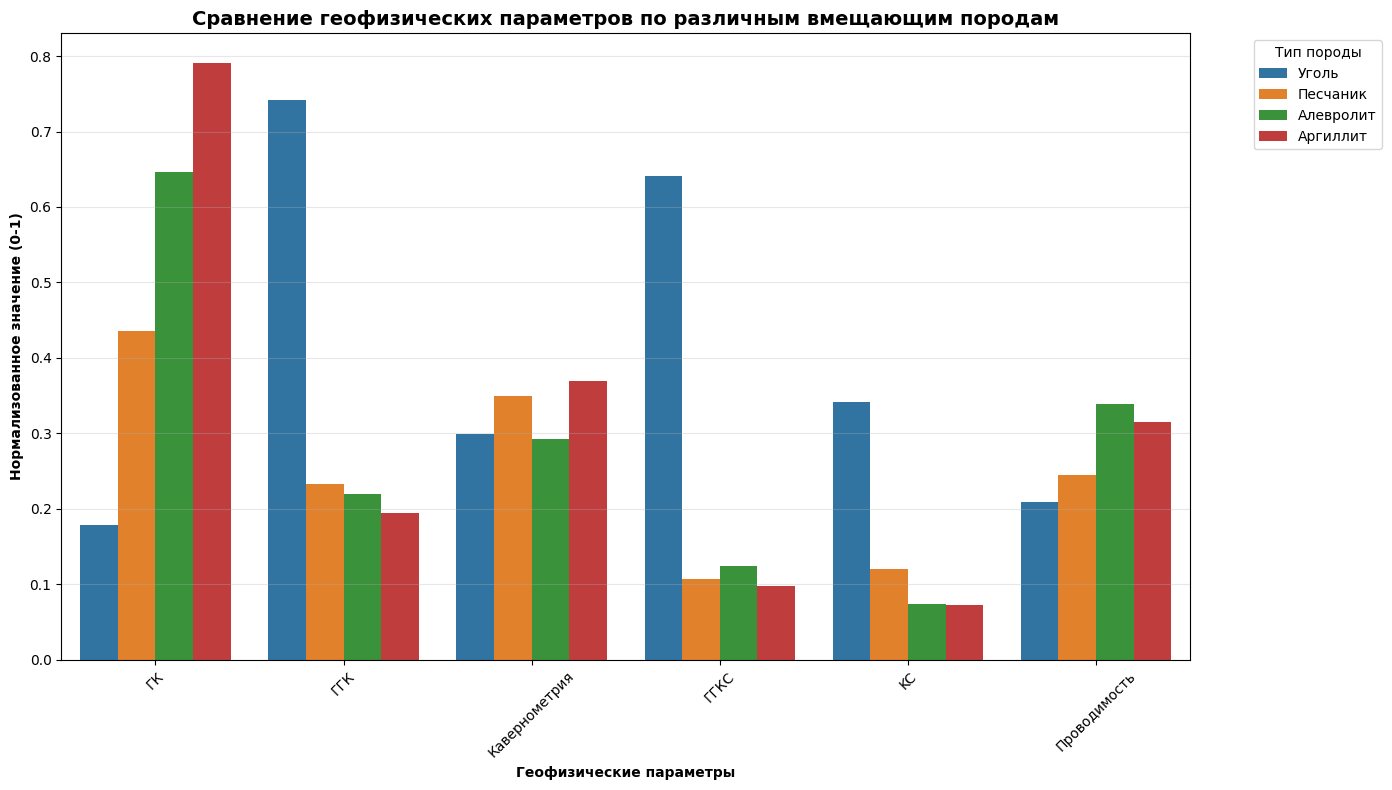

In [ ]:
# График сравнения угля с породами
print("\n" + "="*60)
print("Сравнение угля с вмещающими породами")
print("="*60)

plt.figure(figsize=(14, 8))

# Подготовка данных для группированного bar plot
comparison_data = []
for lith in heatmap_df.index:
    for param in heatmap_df.columns:
        comparison_data.append({
            'Порода': lith,
            'Параметр': param,
            'Значение': heatmap_df.loc[lith, param]
        })

comparison_df = pd.DataFrame(comparison_data)

# Создаем группированный bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_df, x='Параметр', y='Значение', hue='Порода')
plt.title('Сравнение геофизических параметров по различным вмещающим породам',
          fontsize=14, fontweight='bold')
plt.xlabel('Геофизические параметры', fontweight='bold')
plt.ylabel('Нормализованное значение (0-1)', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Тип породы', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Сохранение нормализованного датасета
output_file_normalized = "wells_dataset_normalized.csv"
df_normalized.to_csv(output_file_normalized, index=False, encoding='utf-8')
print(f"\nНормализованный датасет сохранен: {output_file_normalized}")


Нормализованный датасет сохранен: wells_dataset_normalized.csv


In [ ]:
# Анализ мощности угольных пластов по данным ГИС
if 'Угольный пласт' in df_normalized.columns:
    coal_intervals = df_normalized[df_normalized['Горная порода'].str.contains('Уголь', na=False)]

    if len(coal_intervals) > 0:
        print(f"\nАНАЛИЗ УГОЛЬНЫХ ПЛАСТОВ:")
        print("="*40)

        # Группируем по пластам и считаем мощность
        coal_thickness = coal_intervals.groupby('Угольный пласт').agg({
            'Глубина': ['count', 'min', 'max']
        }).round(2)

        coal_thickness['Мощность, м'] = coal_thickness[('Глубина', 'max')] - coal_thickness[('Глубина', 'min')]
        coal_thickness['Точки измерения'] = coal_thickness[('Глубина', 'count')]

        print(coal_thickness[['Мощность, м', 'Точки измерения']].sort_values('Мощность, м', ascending=False).head(10))


АНАЛИЗ УГОЛЬНЫХ ПЛАСТОВ:
                     Мощность, м Точки измерения
                                                
Угольный пласт                                  
Б/н                       429.95             206
б/н                       420.55             542
Сычевский IV в.п(IV)      259.55            4383
Грамотеинский IIIа        198.40            1081
Сычевский III(II)         198.00            2410
Грамотеинский II          196.85            5325
Грамотеинский I           196.10            1422
Сычевский III             192.40             808
Грамотеинский Iа          182.45             290
Сычевский III (II)        163.65            1436


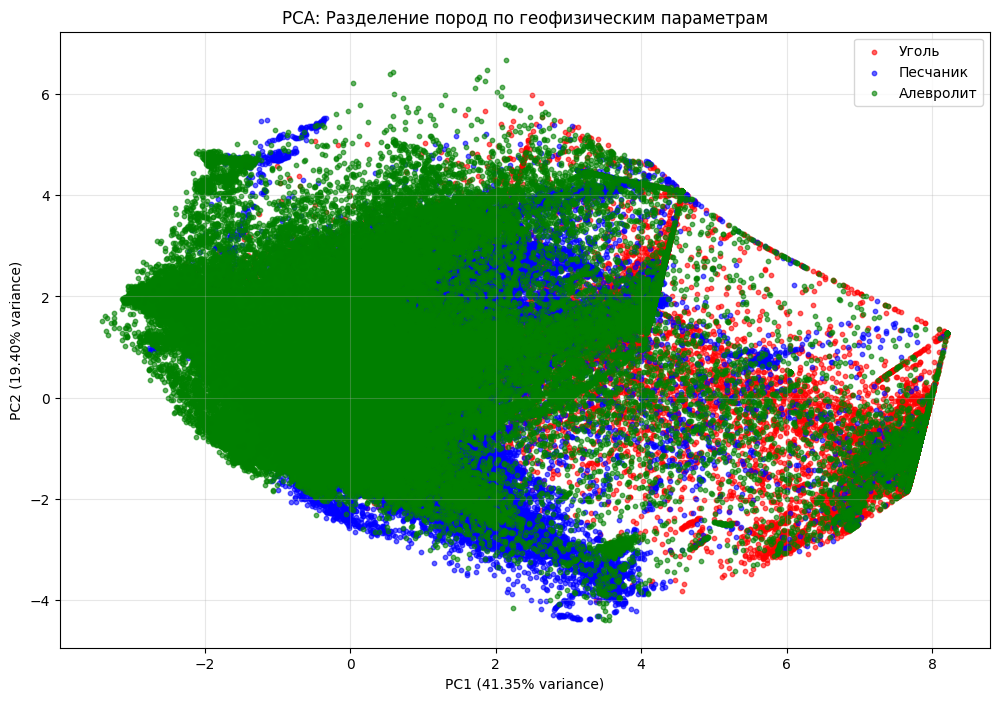


Объяснение дисперсии PCA:
PC1: 41.35%
PC2: 19.40%


In [ ]:
# PCA анализ для выявления скрытых закономерностей

# Подготовка данных для PCA
X_pca = df_normalized[numeric_columns].dropna()
X_scaled = StandardScaler().fit_transform(X_pca)

# Выполняем PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Визуализируем результаты PCA с цветовой кодировкой по литологии
plt.figure(figsize=(12, 8))

# Берем только основные литологические типы для наглядности
main_lithologies = ['Уголь', 'Песчаник', 'Алевролит']
colors = ['red', 'blue', 'green']

for i, lith in enumerate(main_lithologies):
    mask = df_normalized['Горная порода'].str.contains(lith, na=False)
    if mask.sum() > 0:
        plt.scatter(principal_components[mask, 0], principal_components[mask, 1],
                   c=colors[i], label=lith, alpha=0.6, s=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA: Разделение пород по геофизическим параметрам')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nОбъясненные дисперсии PCA:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.2%}")

Из графика видно, что геофизические методы разделяют данные, формируя классы. Это является хорошим признаком для дальнейшего обучения моделей.

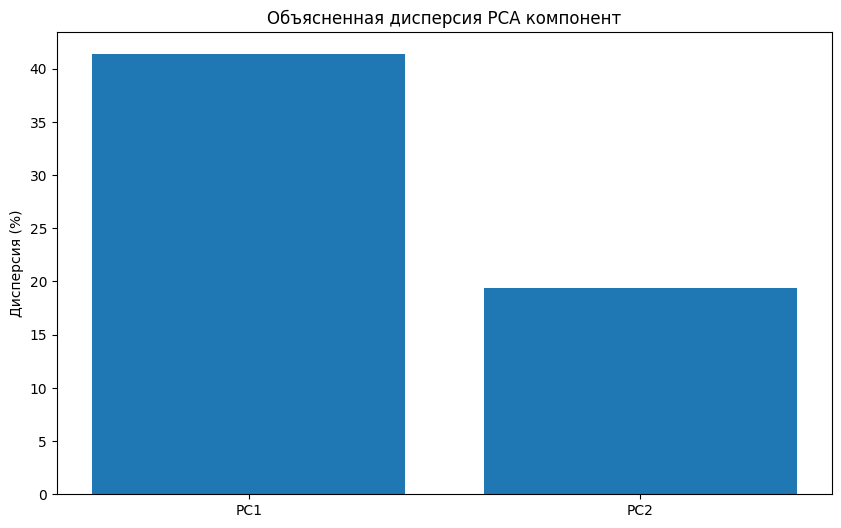

Кумулятивная дисперсия PC1+PC2: 60.75%


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(['PC1', 'PC2'], [41.35, 19.40])
plt.title('Объясненная дисперсия PCA компонент')
plt.ylabel('Дисперсия (%)')
plt.show()

# Кумулятивная дисперсия
cumulative_variance = 41.35 + 19.40
print(f"Кумулятивная дисперсия PC1+PC2: {cumulative_variance:.2f}%")

## Окончательная подготовка датасета для дальнейшего обучения нейронной сети
**Подготовка признаков и целевых переменных**

In [ ]:
# Создаем бинарную метку для угля
df_normalized['is_coal'] = df_normalized['Горная порода'].str.contains('Уголь', na=False).astype(int)

# Основные признаки для классификации (нормализованные)
feature_columns_original = ['ГК', 'ГГК', 'Кавернометрия', 'ГГКС', 'KC', 'Проводимость']
feature_columns = [f'{col}_norm' for col in feature_columns_original]

# Проверяем, что все нормализованные столбцы существуют в датафрейме
available_norm_columns = [col for col in feature_columns if col in df_normalized.columns]
missing_columns = set(feature_columns) - set(available_norm_columns)

if missing_columns:
    print(f"Внимание! Отсутствуют нормализованные столбцы: {missing_columns}")
    print("Доступные нормализованные столбцы:")
    norm_cols_in_df = [col for col in df_normalized.columns if col.endswith('_norm')]
    print(norm_cols_in_df)

print(f"Используемые нормализованные признаки: {available_norm_columns}")

# Проверяем диапазоны нормализованных данных перед заполнением
print("\nПроверка диапазонов нормализованных данных:")
for col in available_norm_columns:
    if col in df_normalized.columns:
        min_val = df_normalized[col].min()
        max_val = df_normalized[col].max()
        missing_count = df_normalized[col].isna().sum()
        print(f"  {col}: [{min_val:.3f}, {max_val:.3f}], пропусков: {missing_count}")

# Создаём чистый датафрейм с нормализованными данными
df_clean = df_normalized[available_norm_columns + ['Горная порода', 'is_coal']].copy()

# Заполняем пропуски в нормализованных данных медианными значениями
#(принял такое решение между нулями, удалением и медианой)
print("\nЗаполнение пропусков в нормализованных данных медианными значениями...")
for col in available_norm_columns:
    missing_count = df_clean[col].isna().sum()
    if missing_count > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"  {col}: заполнено {missing_count} пропусков медианой = {median_val:.3f}")

# Окончательная проверка данных - убеждаемся, что все данные в диапазоне [0, 1]
print("\nОкончательная проверка - диапазоны после заполнения:")
for col in available_norm_columns:
    min_val = df_clean[col].min()
    max_val = df_clean[col].max()
    print(f"  {col}: [{min_val:.3f}, {max_val:.3f}]")

    # Проверяем, что данные в ожидаемом диапазоне
    if min_val < 0 or max_val > 1:
        print(f"Внимание! Данные выходят за пределы [0, 1]!")
    else:
        print(f"Отлично! Данные в диапазоне [0, 1]")

print(f"\nИтоговый размер датасета: {len(df_clean)}")
print(f"Осталось пропусков: {df_clean[available_norm_columns].isna().sum().sum()}")
print(f"Баланс классов угля:")
print(df_clean['is_coal'].value_counts())

# Кодирование литологии для многоклассовой классификации
le = LabelEncoder()
df_clean['lithology_encoded'] = le.fit_transform(df_clean['Горная порода'])

print(f"\nКлассы литологии: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Используемые нормализованные признаки: ['ГК_norm', 'ГГК_norm', 'Кавернометрия_norm', 'ГГКС_norm', 'KC_norm', 'Проводимость_norm']

Проверка диапазонов нормализованных данных:
  ГК_norm: [0.000, 1.000], пропусков: 0
  ГГК_norm: [0.000, 1.000], пропусков: 0
  Кавернометрия_norm: [0.000, 1.000], пропусков: 0
  ГГКС_norm: [0.000, 1.000], пропусков: 0
  KC_norm: [0.000, 1.000], пропусков: 0
  Проводимость_norm: [0.000, 1.000], пропусков: 0

Заполнение пропусков в нормализованных данных медианными значениями...

Окончательная проверка - диапазоны после заполнения:
  ГК_norm: [0.000, 1.000]
Отлично! Данные в диапазоне [0, 1]
  ГГК_norm: [0.000, 1.000]
Отлично! Данные в диапазоне [0, 1]
  Кавернометрия_norm: [0.000, 1.000]
Отлично! Данные в диапазоне [0, 1]
  ГГКС_norm: [0.000, 1.000]
Отлично! Данные в диапазоне [0, 1]
  KC_norm: [0.000, 1.000]
Отлично! Данные в диапазоне [0, 1]
  Проводимость_norm: [0.000, 1.000]
Отлично! Данные в диапазоне [0, 1]

Итоговый размер датасета: 655553
Осталось пр

**Создание наборов данных для обучения и тестирования**

In [ ]:
# Разделение на признаки и целевые переменные
X = df_clean[feature_columns]
y_lithology = df_clean['lithology_encoded']  # Многоклассовая классификация
y_coal = df_clean['is_coal']  # Бинарная классификация

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_lith_train, y_lith_test, y_coal_train, y_coal_test = train_test_split(
    X, y_lithology, y_coal, test_size=0.2, random_state=42, stratify=y_lithology
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Проверяем, что данные остались в нормализованном диапазоне
print(f"\nПроверка диапазонов после разделения:")
print(f"Обучающая выборка: [{X_train.min().min():.3f}, {X_train.max().max():.3f}]")
print(f"Тестовая выборка: [{X_test.min().min():.3f}, {X_test.max().max():.3f}]")

# Дополнительная проверка по каждому признаку
print(f"\nДиапазоны по каждому признаку в обучающей выборке:")
for col in available_norm_columns:
    min_val = X_train[col].min()
    max_val = X_train[col].max()
    print(f"  {col}: [{min_val:.3f}, {max_val:.3f}]")

Размер обучающей выборки: (524442, 6)
Размер тестовой выборки: (131111, 6)

Проверка диапазонов после разделения:
Обучающая выборка: [0.000, 1.000]
Тестовая выборка: [0.000, 1.000]

Диапазоны по каждому признаку в обучающей выборке:
  ГК_norm: [0.000, 1.000]
  ГГК_norm: [0.000, 1.000]
  Кавернометрия_norm: [0.000, 1.000]
  ГГКС_norm: [0.000, 1.000]
  KC_norm: [0.000, 1.000]
  Проводимость_norm: [0.000, 1.000]


**Архитектура нейронной сети**

In [ ]:
def create_lithology_model(input_dim, num_classes):
    """Создает модель для классификации литологии"""
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(), # Cтабилизируеv обучение
        layers.Dropout(0.3), # Регулируем переобучение

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax') # Для многоклассовой классификации
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_coal_detection_model(input_dim):
    """Создает модель для детекции угольных пластов"""
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(), # Ускоряет обучение, стабилизирует градиенты
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(1, activation='sigmoid') # Бинарная классификация
    ])

    # Попробуем стандартную оптимизацию
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

**Обучение моделей**

In [ ]:
# Модель для классификации литологии
# Автоматически определяем число классов
num_lithology_classes = len(le.classes_)
lithology_model = create_lithology_model(X_train.shape[1], num_lithology_classes)

print("Архитектура модели классификации литологии:")
lithology_model.summary()

# Обучение модели литологии
lith_history = lithology_model.fit(
    X_train, y_lith_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=15,
            restore_best_weights=True,
            monitor='val_accuracy'),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=10,
            factor=0.5,
            min_lr=1e-7),
        keras.callbacks.TensorBoard(log_dir='logs/lithology')
        ]
)

Архитектура модели классификации литологии:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,019 (50.86 KB)

 Trainable params: 12,571 (49.11 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.3662 - loss: 2.1521 - val_accuracy: 0.4403 - val_loss: 1.5867 - learning_rate: 0.0010
Epoch 2/100
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4283 - loss: 1.6368 - val_accuracy: 0.4449 - val_loss: 1.5656 - learning_rate: 0.0010
Epoch 3/100
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4361 - loss: 1.6112 - val_accuracy: 0.4493 - val_loss: 1.5497 - learning_rate: 0.0010
Epoch 4/100
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4401 - loss: 1.5953 - val_accuracy: 0.4496 - val_loss: 1.5413 - learning_rate: 0.0010
Epoch 5/100
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4429 - loss: 1.5898 - val_accuracy: 0.4547 - val_loss: 1.5362 - learning_rate: 0.0010
Epoch 6/100
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4434 - loss: 1.5849 - val_accuracy: 0.4592 - val_loss: 1.5254 - learning_rate: 0.0010
Epoch 7/100
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accura

In [ ]:
# Модель для детекции угля
coal_model = create_coal_detection_model(X_train.shape[1])

print("\nАрхитектура модели детекции угля:")
coal_model.summary()

# Обучение модели детекции угля
coal_history = coal_model.fit(
    X_train, y_coal_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=15,
            restore_best_weights=True,
            monitor='val_accuracy'
        ),
        keras.callbacks.ReduceLROnPlateau(
            patience=10,
            factor=0.5,
            min_lr=1e-7
        )
    ]
)


Архитектура модели детекции угля:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100
6556/6556 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.9379 - loss: 0.1856 - precision: 0.5392 - recall: 0.5794 - val_accuracy: 0.9662 - val_loss: 0.1055 - val_precision: 0.7244 - val_recall: 0.6417 - learning_rate: 0.0010
Epoch 2/100
6556/6556 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9659 - loss: 0.1098 - precision: 0.7352 - recall: 0.6084 - val_accuracy: 0.9670 - val_loss: 0.1038 - val_precision: 0.7367 - val_recall: 0.6422 - learning_rate: 0.0010
Epoch 3/100
6556/6556 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9664 - loss: 0.1084 - precision: 0.7445 - recall: 0.6099 - val_accuracy: 0.9671 - val_loss: 0.1034 - val_precision: 0.7295 - val_recall: 0.6570 - learning_rate: 0.0010
Epoch 4/100
6556/6556 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9666 - loss: 0.1066 - precision: 0.7422 - recall: 0.6162 - val_accuracy: 0.9670 - val_loss: 0.1032 - val_precision: 0.7597 - val_recall: 0.6014 - learning_rate: 0.0010
Epoch 5/100
6556/6556 ━━━━━━━━━━━━━━━━━━━━ 26s 4

#Оценка моделей

In [ ]:
def plot_training_history(history, title):
    """Визуализация процесса обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

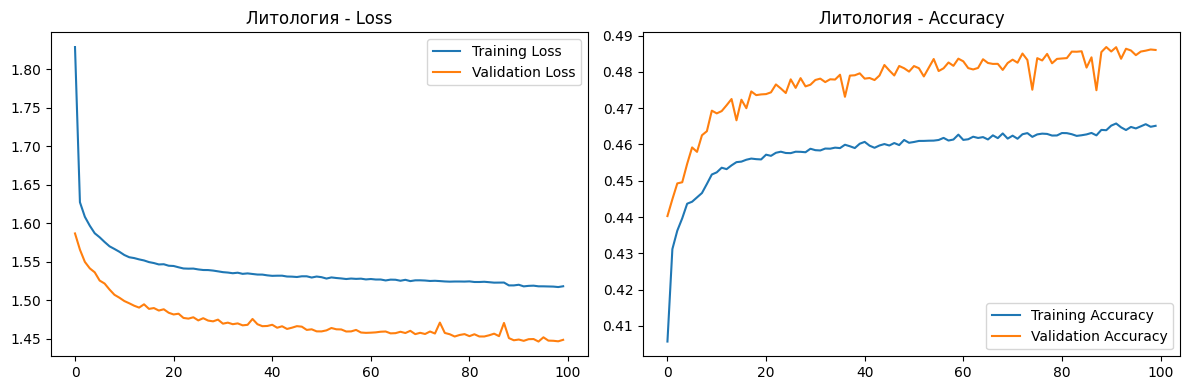

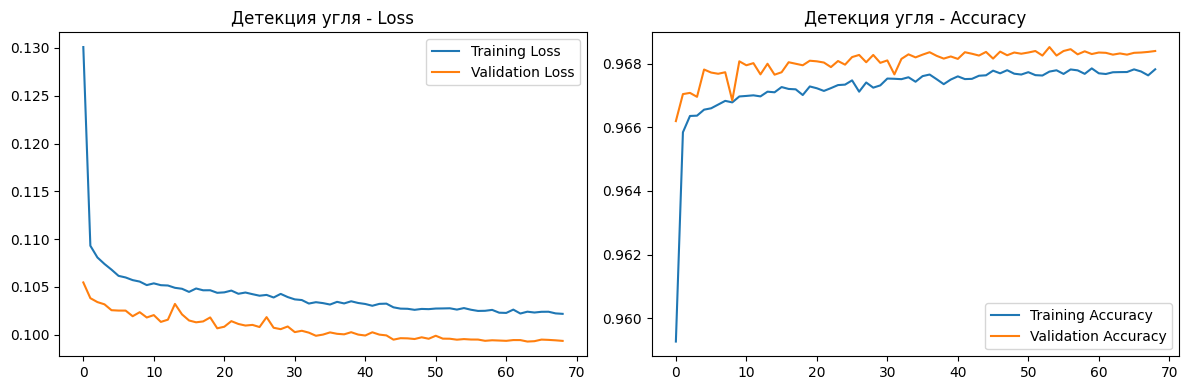


Результаты на тестовых данных:
Литология - Точность: 0.4865
Уголь - Точность: 0.9686, Точность: 0.7669, Полнота: 0.6340
4098/4098 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Отчет по классификации литологии (простой):
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      6688
           1       0.51      0.82      0.63     47943
           2       0.40      0.00      0.00      1006
           3       0.00      0.00      0.00      1354
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00       351
           7       0.75      0.31      0.44       294
           8       0.00      0.00      0.00        77
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00        38
          11       0.00      0.00      0.00       119
          12       0.00      0.00      0.00        14
          13       0.00      0.00 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Визуализация обучения
plot_training_history(lith_history, 'Литология')
plot_training_history(coal_history, 'Детекция угля')

# Оценка на тестовых данных
lith_test_loss, lith_test_acc = lithology_model.evaluate(X_test, y_lith_test, verbose=0)
coal_test_loss, coal_test_acc, coal_test_precision, coal_test_recall = coal_model.evaluate(X_test, y_coal_test, verbose=0)

print(f"\nРезультаты на тестовых данных:")
print(f"Литология - Точность: {lith_test_acc:.4f}")
print(f"Уголь - Точность: {coal_test_acc:.4f}, Точность: {coal_test_precision:.4f}, Полнота: {coal_test_recall:.4f}")

# Детальная классификация литологии
y_lith_pred = lithology_model.predict(X_test)
y_lith_pred_classes = np.argmax(y_lith_pred, axis=1)

print("\nОтчет по классификации литологии (простой):")
print(classification_report(y_lith_test, y_lith_pred_classes))

# Точность по углю отдельно
coal_label = le.transform(['Уголь(IV)'])[0]
coal_mask = y_lith_test == coal_label
coal_accuracy = (y_lith_pred_classes[coal_mask] == coal_label).mean()

print(f"\nТочность определения угля: {coal_accuracy:.4f}")

## Прогнозирование на новых данных

In [ ]:
def predict_lithology_and_coal(model_lith, model_coal, new_data):
    """Функция для прогнозирования литологии и угольных пластов"""

    # Прогнозирование
    lithology_probs = model_lith.predict(new_data)
    lithology_pred = np.argmax(lithology_probs, axis=1)
    lithology_labels = le.inverse_transform(lithology_pred)

    coal_probs = model_coal.predict(new_data)
    coal_pred = (coal_probs > 0.5).astype(int).flatten()

    return lithology_labels, lithology_probs, coal_pred, coal_probs

sample_data = X_test[:5]  # Берем несколько примеров из тестовой выборки
lith_pred, lith_probs, coal_pred, coal_probs = predict_lithology_and_coal(
    lithology_model, coal_model, sample_data
)

print("\nПрогнозирование:")
for i in range(len(sample_data)):
    print(f"Образец {i+1}:")
    print(f"  Предсказанная литология: {lith_pred[i]}")
    print(f"  Вероятность угля: {coal_probs[i][0]:.4f}")
    print(f"  Угольный пласт: {'Да' if coal_pred[i] else 'Нет'}")
    print(f"  Фактическая литология: {le.inverse_transform([y_lith_test.iloc[i]])[0]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step

Пример прогнозирования:
Образец 1:
  Предсказанная литология: Уголь(IV)
  Вероятность угля: 0.7605
  Угольный пласт: Да
  Фактическая литология: Переслаивание алевролита и песчаника(VIII)

Образец 2:
  Предсказанная литология: Песчаник среднезернистый(VIII)
  Вероятность угля: 0.0035
  Угольный пласт: Нет
  Фактическая литология: Песчаник мелкозернистый(VIII)

Образец 3:
  Предсказанная литология: Алевролит мелкозернистый(VI)
  Вероятность угля: 0.0351
  Угольный пласт: Нет
  Фактическая литология: Алевролит мелкозернистый(VI)

Образец 4:
  Предсказанная литология: Песчаник среднезернистый(VIII)
  Вероятность угля: 0.0189
  Угольный пласт: Нет
  Фактическая литология: Песчаник среднезернистый(VIII)

Образец 5:
  Предсказанная литология: Песчаник среднезернистый(VIII)
  Вероятность угля: 0.0024
  Угольный пласт: Нет
  Фактическая литология: Песчаник среднезернистый(VIII)



Образец 1 - дал ошибочный прогноз. Всего из 5 образцов одна ошибка.

Возможные причины:
- Сложный геологический объект (переслаивание)
- Геофизические характеристики похожи на угольные пласты
- Ошибка в разметке тренировочных данных



## Попытка балансировки сокращение классов

In [ ]:
# Включаем только основные классы для быстрого обучения
main_classes = ['Уголь(IV)', 'Песчаник мелкозернистый(VIII)', 'Алевролит мелкозернистый(VI)']
df_main = df[df['Горная порода'].isin(main_classes)].copy()

print(f"Размер датасета с основными классами: {len(df_main)}")
print(df_main['Горная порода'].value_counts())

# Используем только информативные признаки
feature_columns = ['ГК', 'ГГК', 'ГГКС', 'KC']  # Самые полезные по нашему анализу
X = df_main[feature_columns].fillna(0)

# Кодируем целевую переменную
le = LabelEncoder()
y = le.fit_transform(df_main['Горная порода'])

print(f"Классы: {dict(zip(le.classes_, range(len(le.classes_))))}")
print(f"Уникальные значения в y: {np.unique(y)}")

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Уникальные значения в y_train: {np.unique(y_train)}")

# Модель для классификации
def create_simple_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(), # Стабилизируем обучение
        layers.Dropout(0.3), # Регулируем переобучение

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax') # Для многоклассовой классификации
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Создаем и обучаем модель
simple_model = create_simple_model(X_train.shape[1], len(main_classes))


history = simple_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=15,
            restore_best_weights=True,
            monitor='val_accuracy'),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=10,
            factor=0.5,
            min_lr=1e-7),
        keras.callbacks.TensorBoard(log_dir='logs/lithology_test')
    ]
)

Размер датасета с основными классами: 347765
Горная порода
Алевролит мелкозернистый(VI)     239712
Песчаник мелкозернистый(VIII)     71275
Уголь(IV)                         36778
Name: count, dtype: int64
Классы: {'Алевролит мелкозернистый(VI)': 0, 'Песчаник мелкозернистый(VIII)': 1, 'Уголь(IV)': 2}
Уникальные значения в y: [0 1 2]
Обучающая выборка: (278212, 4)
Тестовая выборка: (69553, 4)
Уникальные значения в y_train: [0 1 2]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5656 - loss: 1.0886 - val_accuracy: 0.7298 - val_loss: 0.7070 - learning_rate: 1.0000e-04
Epoch 2/100
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7169 - loss: 0.7576 - val_accuracy: 0.7299 - val_loss: 0.6950 - learning_rate: 1.0000e-04
Epoch 3/100
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7201 - loss: 0.7248 - val_accuracy: 0.7304 - val_loss: 0.6889 - learning_rate: 1.0000e-04
Epoch 4/100
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7228 - loss: 0.7099 - val_accuracy: 0.7325 - val_loss: 0.6735 - learning_rate: 1.0000e-04
Epoch 5/100
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7304 - loss: 0.6915 - val_accuracy: 0.7390 - val_loss: 0.6631 - learning_rate: 1.0000e-04
Epoch 6/100
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7328 - loss: 0.6810 - val_accuracy: 0.7405 - val_loss: 0.6581 - learning_rate: 1.0000e-04
Epoch 7/100
3478/3478 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Оценка
test_loss, test_acc = simple_model.evaluate(X_test, y_test, verbose=0)
print(f"\nТочность на тесте: {test_acc:.4f}")

# Прогноз
print("\nПрогноз:")
sample_indices = [0, 1, 2, 3, 4]
for i in sample_indices:
    sample = X_test.iloc[i:i+1] if hasattr(X_test, 'iloc') else X_test[i:i+1]
    prediction = simple_model.predict(sample, verbose=0)
    pred_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])

    print(f"Образец {i+1}:")
    print(f"  Прогноз: {le.classes_[pred_class]} (уверенность: {confidence:.2f})")
    print(f"  Фактически: {le.classes_[y_test[i]]}")
    print()


Точность на тесте: 0.7489

Прогноз:
Образец 1:
  Прогноз: Алевролит мелкозернистый(VI) (уверенность: 0.71)
  Фактически: Алевролит мелкозернистый(VI)

Образец 2:
  Прогноз: Алевролит мелкозернистый(VI) (уверенность: 0.66)
  Фактически: Алевролит мелкозернистый(VI)

Образец 3:
  Прогноз: Алевролит мелкозернистый(VI) (уверенность: 0.70)
  Фактически: Алевролит мелкозернистый(VI)

Образец 4:
  Прогноз: Уголь(IV) (уверенность: 0.46)
  Фактически: Уголь(IV)

Образец 5:
  Прогноз: Алевролит мелкозернистый(VI) (уверенность: 0.71)
  Фактически: Алевролит мелкозернистый(VI)

